In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

# Get data

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/"train"
test_dir = image_path/"test"

In [5]:
IMG_SIZE=224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manualy created transforms: {manual_transforms}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
type(manual_transforms)

torchvision.transforms.transforms.Compose

In [7]:
# Dataloader for images
BATCH_SIZE = 32  # Higher number of batch size, the more computation power is needed

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir, 
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f788da99b90>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

# Eq 1: Split the data into patches, then creating the class, position, and patch embedding.   

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

```

### 1. Calculating patch embedding input and output shapes

In [9]:
# Create example values
height = 224        # height
width = 224         # width
color_channels = 3  # channel 
patch_size = 16     # P

# Calculate N (num of patches)
num_of_patches = int((height * width) / patch_size**2)
print(f'Num of patch (N) with image height (G={height}), width (W={width}), and patch size (P={patch_size}): {num_of_patches} ')


Num of patch (N) with image height (G=224), width (W=224), and patch size (P=16): 196 


In [10]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f'input: {embedding_layer_input_shape}')
print(f'output: {embedding_layer_output_shape}')

input: (224, 224, 3)
output: (196, 768)


### 2. Convert an image into patches 

(-0.5, 223.5, 223.5, -0.5)

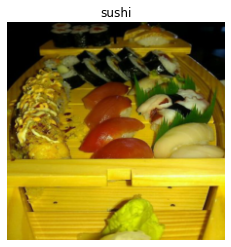

In [11]:
# view the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

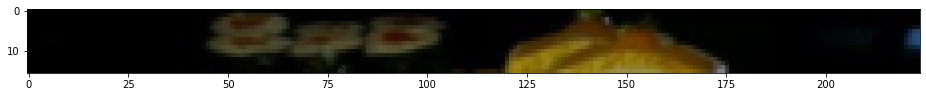

In [12]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

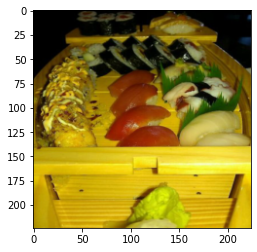

In [13]:
plt.imshow(image_permuted)

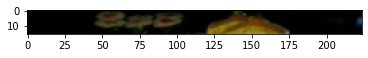

In [14]:
plt.imshow(image_permuted[:16, :, :])

Num of patches per row: 14.0
Patch size: 16 * 16


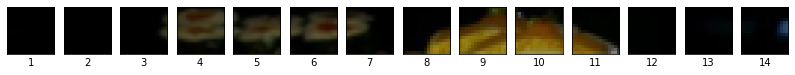

In [15]:
# Setup hyperparameters and make sure image_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patchs = img_size / patch_size
assert img_size % patch_size == 0
print(f'Num of patches per row: {num_patchs}\nPatch size: {patch_size} * {patch_size}')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patchs, num_patchs),
                        sharex=True,
                        sharey=True)

# Iterate through num of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Num of patches per row: 14.0        
Num of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 * 16


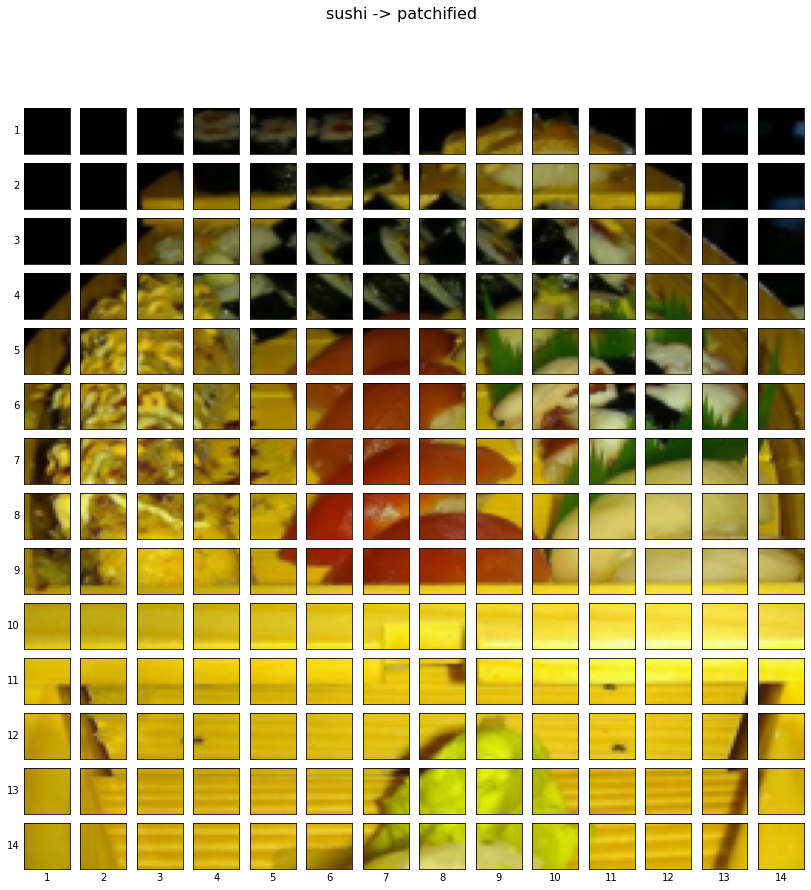

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f'Num of patches per row: {num_patches}\
        \nNum of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} * {patch_size}')

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of img
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        # Plot the permuted img patch (img_permuted ->(height, width, channel))
        axs[i, j].imshow(image_permuted[patch_height: patch_height+patch_size,
                                        patch_width: patch_width+patch_size,
                                        :])
        
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=16)
plt.show()

### 3. Creating image patches with torch.nn.Conv2d() 
*By setting the `kernel_size` and `stride` parameters of a [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer equal to the `patch_size`, we can effectively get a layer that splits our image into patches and creates a learnable embedding*


**input**: $H * W * C$   
**2D img**: (224,224,3)->(height, width, colorChannels)

**output**: $N * \bigg(P^2 \cdot  C \bigg)$
**flattened 2d patches**: (192,768)->(num of patches, embedding dims)

`torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.   
`torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

In [17]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,    # num of color-channels
                   out_channels=768, # embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

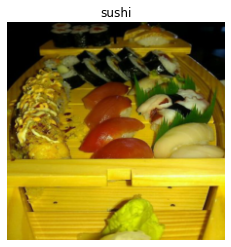

In [18]:
# view the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [19]:
# pass the img through the cnn 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dim
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [20]:
image.shape

torch.Size([3, 224, 224])

In [23]:
# # Plot random 5 convolutional feature maps

# import random
# random_indexes = random.sample(range(0, 758), k=5)
# print(f"howing random convolutinal feature maps from indexes: {random_indexes}")

# # Create plot
# fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# # plot random image feature maps
# for i, idx in enumerate(random_indexes):
#     image_conv_feature_map = image_out_of_conv[:, idx, :, :]
# #     axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
#     axs[i].imshow(image_conv_feature_map.squeeze())
#     axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

howing random convolutinal feature maps from indexes: [442, 98, 57, 753, 528]


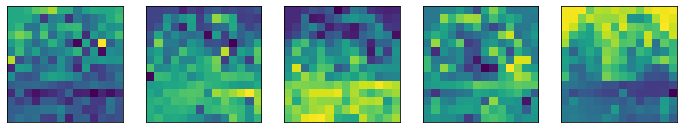

In [24]:
# Plot random 5 convolutional feature maps

import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"howing random convolutinal feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [25]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map

tensor([[[ 0.0114,  0.0117,  0.0331, -0.0245, -0.0628, -0.0357, -0.0479,
          -0.0225, -0.0712, -0.1303, -0.1171,  0.0114,  0.0061, -0.0182],
         [ 0.0117,  0.0103, -0.1201, -0.0704, -0.1030, -0.1869, -0.0621,
           0.0254, -0.0396, -0.1443, -0.0703, -0.1706,  0.0084, -0.0490],
         [ 0.0117,  0.0020, -0.0102, -0.0058,  0.0075, -0.1126, -0.0439,
           0.0047, -0.0191, -0.0657, -0.1861, -0.0080, -0.0863, -0.0040],
         [ 0.0014, -0.1016, -0.2155, -0.0799, -0.0523,  0.0187, -0.0510,
          -0.1212, -0.0422, -0.1695, -0.0636,  0.0054, -0.0360, -0.1571],
         [-0.0358, -0.1521, -0.0683, -0.0088, -0.1307, -0.0665, -0.0202,
          -0.0209, -0.0523, -0.0639,  0.0326, -0.3133, -0.0499, -0.0020],
         [-0.0454, -0.0721, -0.0745, -0.0191, -0.1057, -0.0097, -0.0407,
          -0.0936, -0.1199, -0.2260, -0.2226, -0.0506, -0.2605, -0.0705],
         [-0.0285, -0.0497, -0.1879, -0.0619, -0.0690,  0.0157, -0.0276,
           0.0246, -0.0358, -0.1750, -0.0553,

In [26]:
single_feature_map.requires_grad

True

### 4. Flattening the patch embedding 
`torch.nn.Flatten()`

In [27]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding, map_height, map_width,]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding, map_height, map_width,]


In [28]:
# current tensor shape -> [1,768,14,14]
# start_dim=2 -> [1,768, 14*, 14]
# end_dim=3 -> [1,768, 14, 14*]

flattened = nn.Flatten(start_dim=2,   # flatten feature_map_height (dim2)
                       end_dim=3)     # flatten feature_map_width (dim3)
flattened.shape

AttributeError: 'Flatten' object has no attribute 'shape'

### Put all together

Original image shape -> torch.Size([3, 224, 224])
potted image shape -> torch.Size([224, 224, 3])


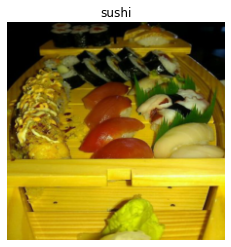

In [29]:
# 1. View a single image

plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])
print(f"Original image shape -> {image.shape}")
print(f"potted image shape -> {image.permute(1,2,0).shape}")

In [30]:
# 2. Turn image into feature maps

image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dim to it
print(f"Image feature map shape -> {image_out_of_conv.shape}")

Image feature map shape -> torch.Size([1, 768, 14, 14])


In [31]:
# 3. Flatten the feature maps

image_out_of_conv_flattened = flattened(image_out_of_conv)
print(f"Flattened image feature map shape -> {image_out_of_conv_flattened.shape}")

Flattened image feature map shape -> torch.Size([1, 768, 196])


In [32]:
# Reshape the flattended feature maps -> the desired output feature maps
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape now -> {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape now -> torch.Size([1, 196, 768])


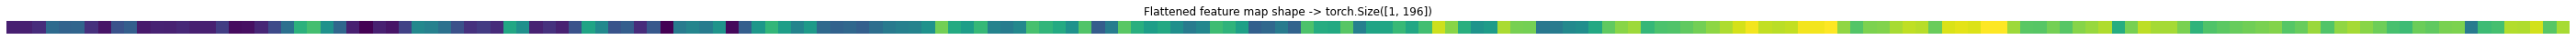

In [33]:
# Single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 150] # [batch, num_patches, embedding_dim]

# Plot the flattened feature map
plt.figure(figsize=(50,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape -> {single_flattened_feature_map.shape}")
plt.axis(False);

In [34]:
image_out_of_conv_flattened_reshaped[:, :, 1].shape

torch.Size([1, 196])

/tmp/ipykernel_5247/68054530.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(22,22))


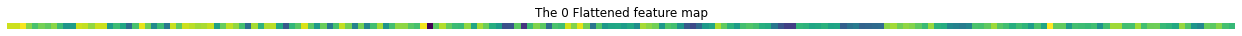

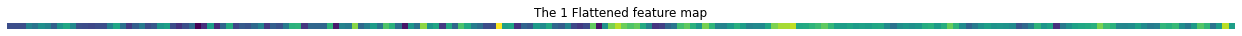

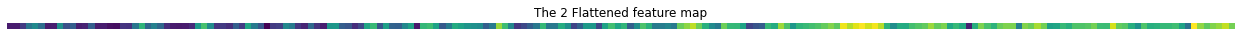

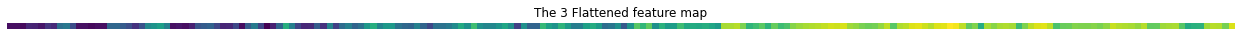

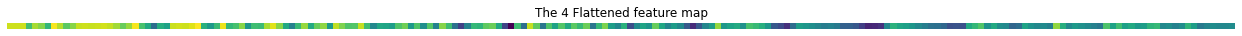

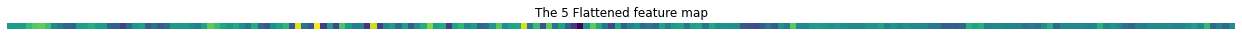

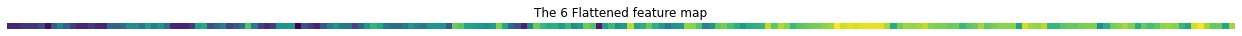

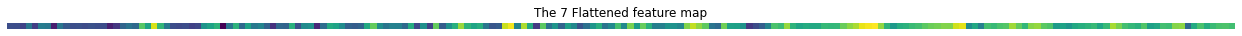

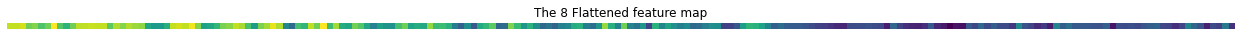

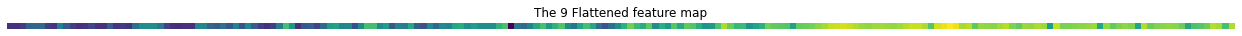

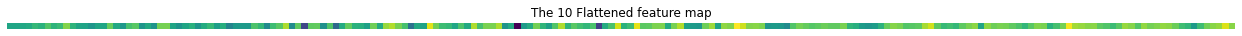

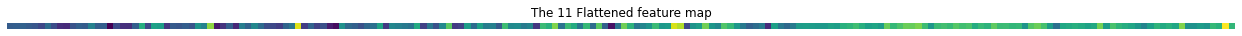

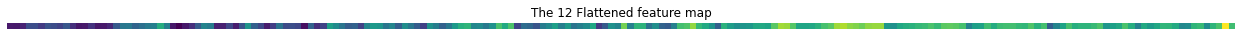

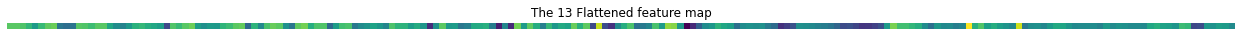

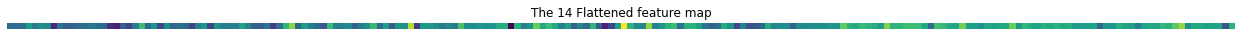

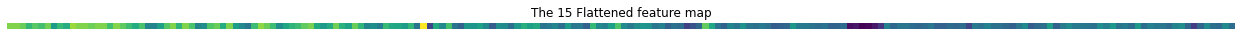

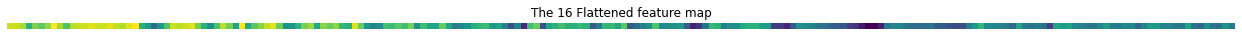

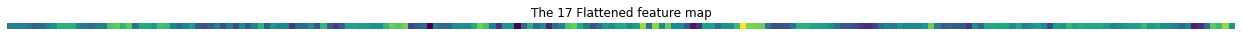

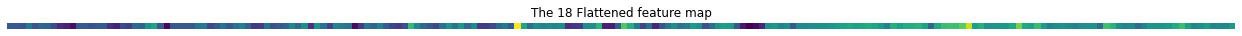

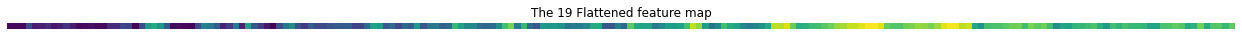

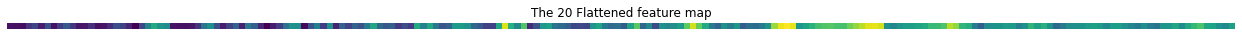

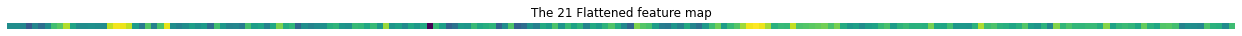

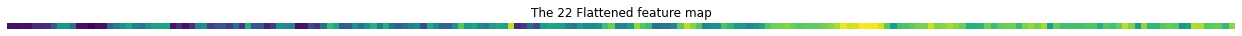

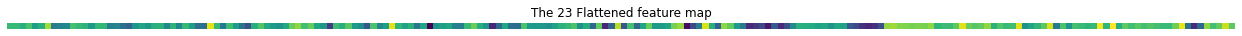

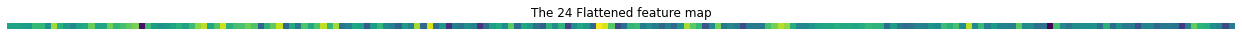

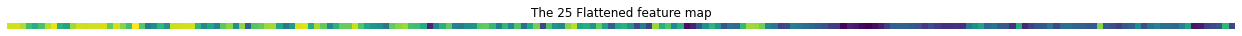

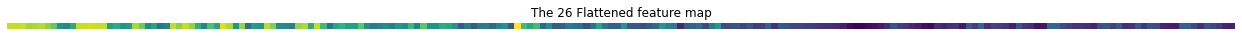

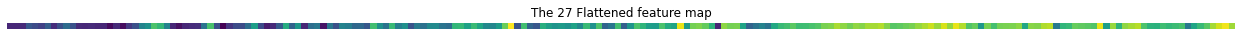

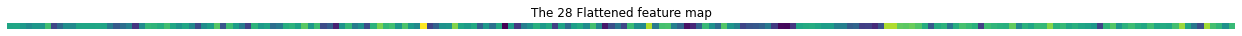

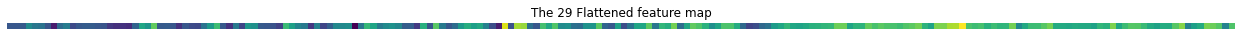

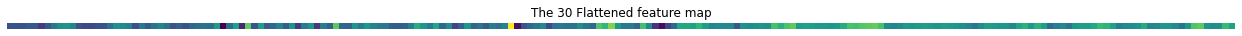

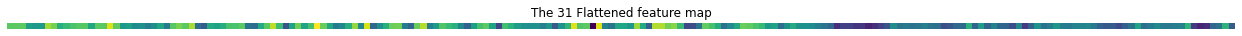

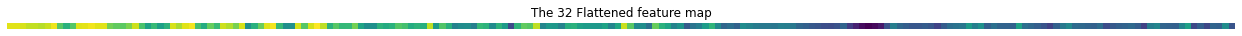

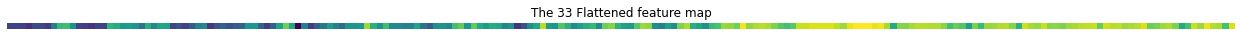

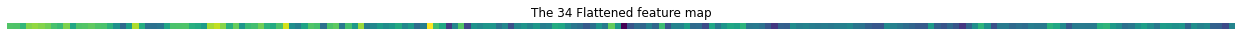

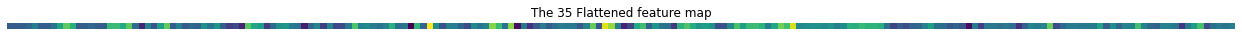

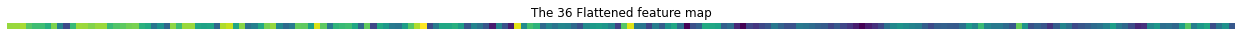

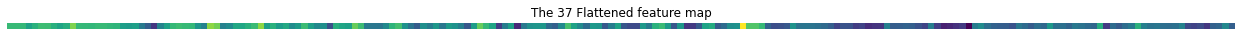

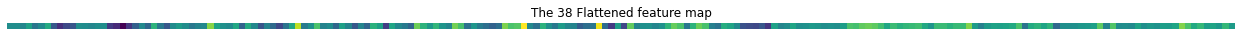

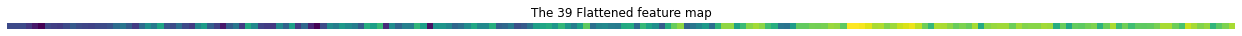

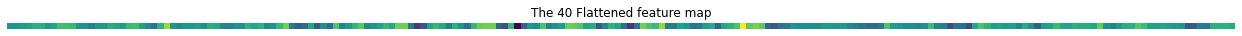

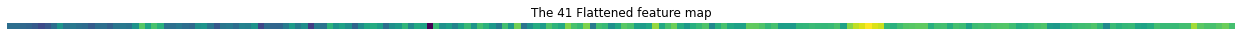

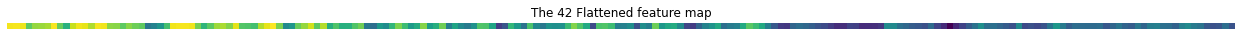

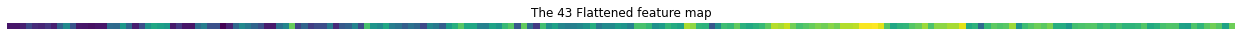

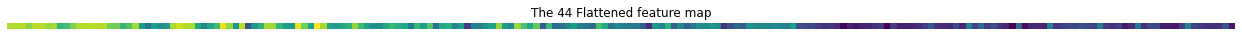

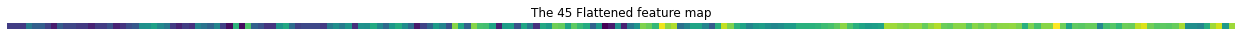

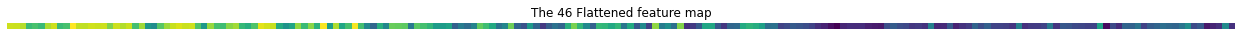

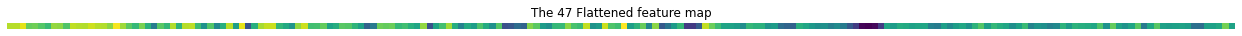

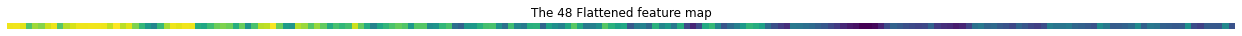

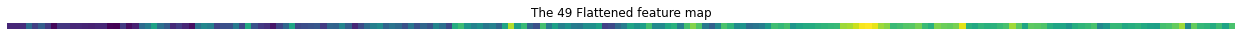

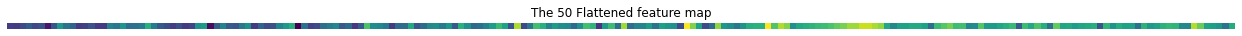

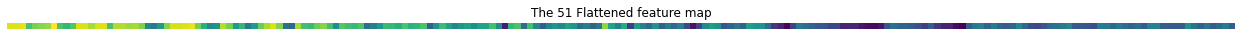

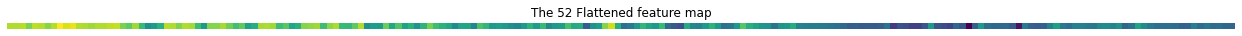

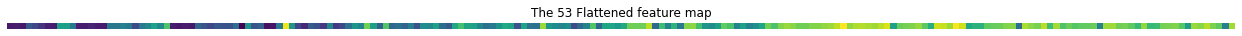

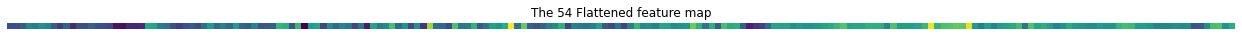

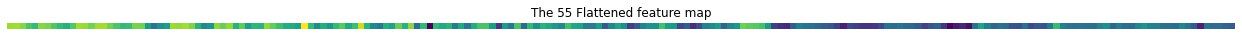

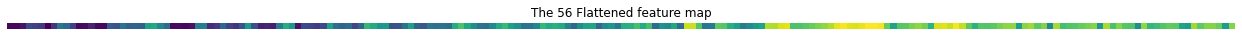

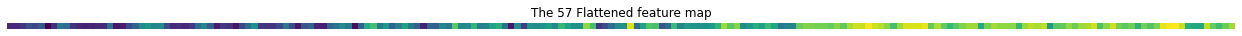

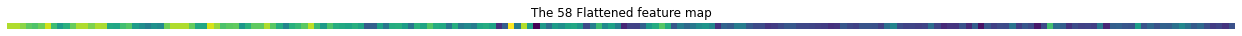

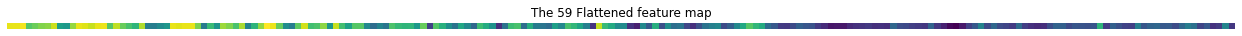

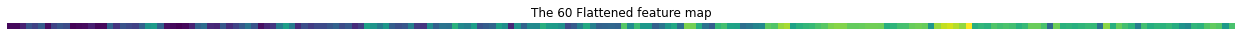

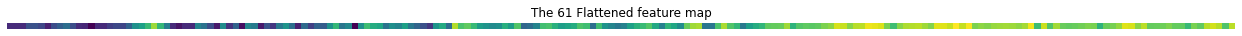

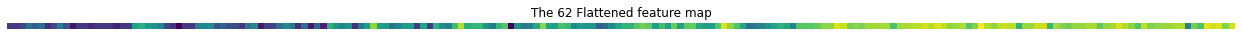

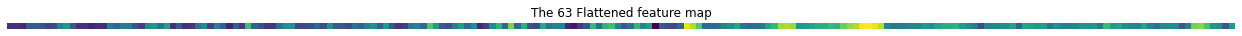

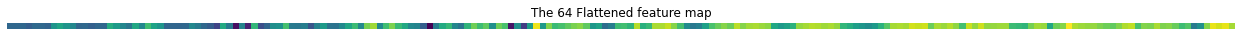

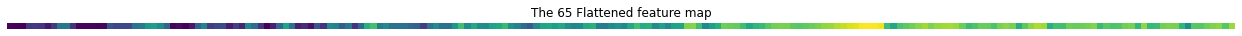

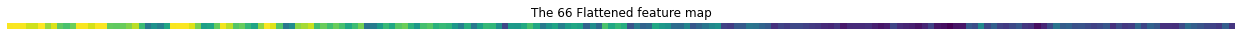

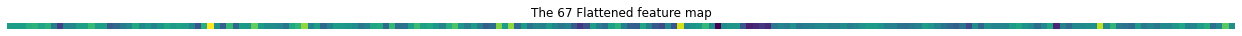

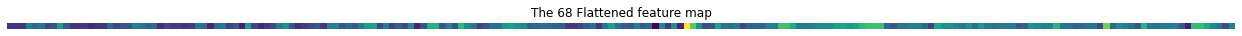

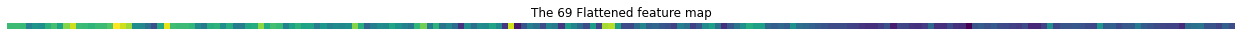

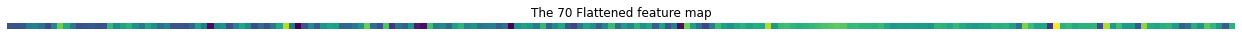

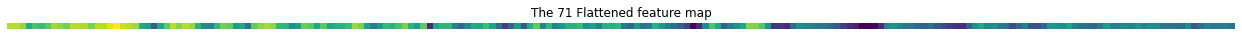

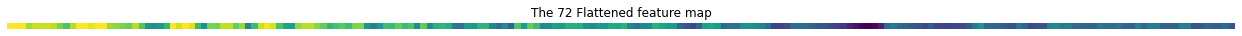

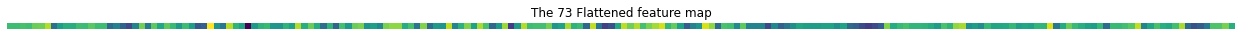

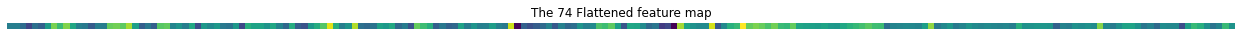

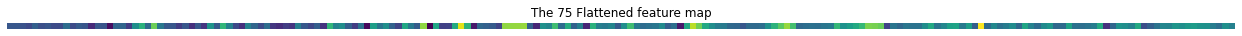

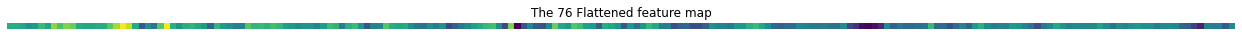

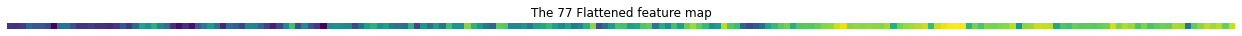

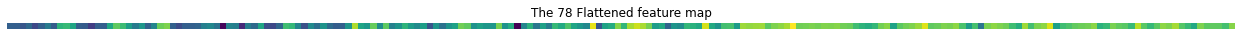

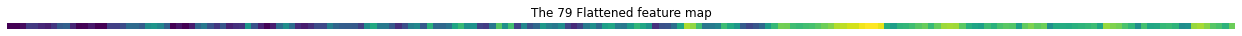

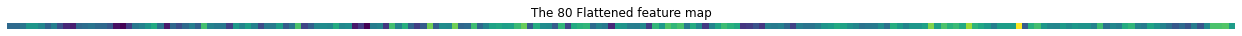

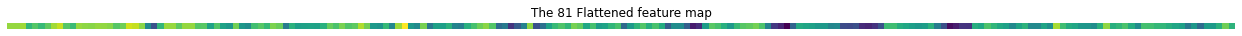

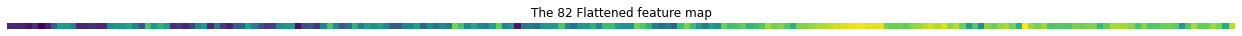

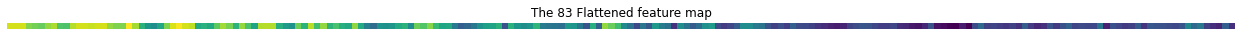

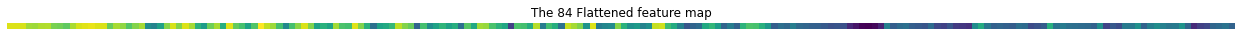

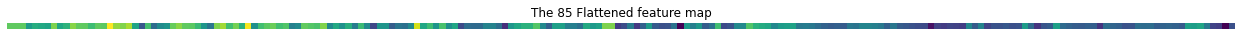

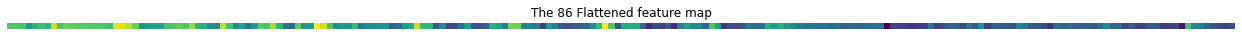

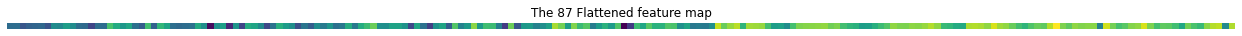

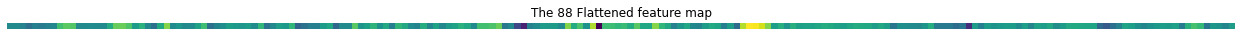

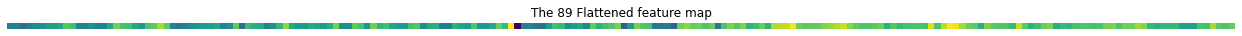

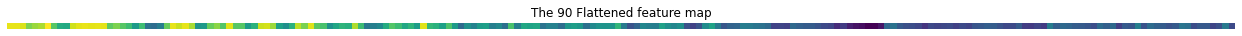

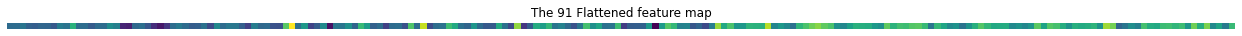

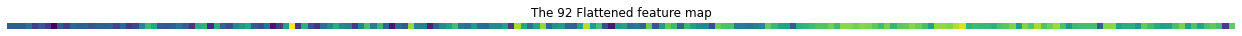

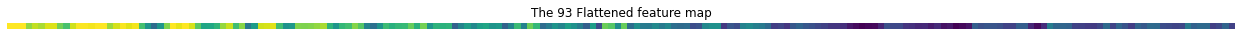

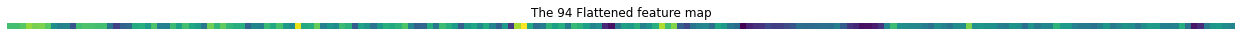

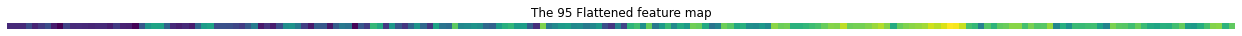

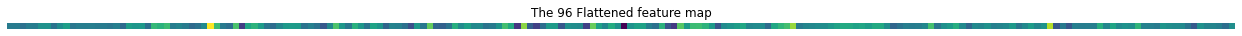

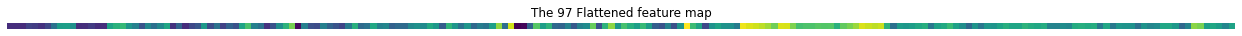

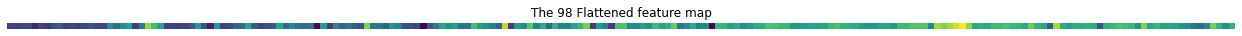

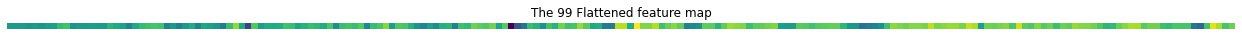

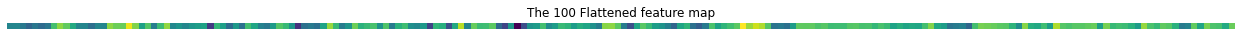

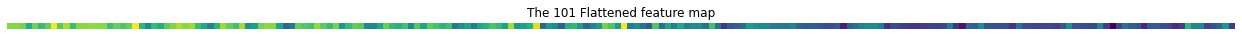

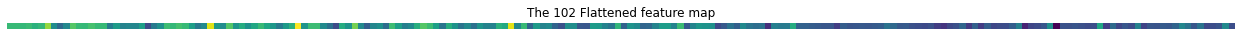

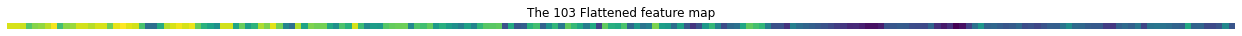

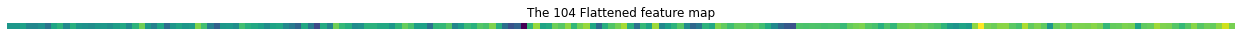

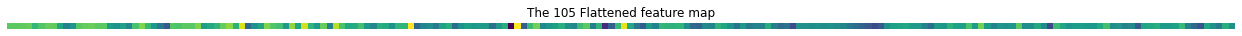

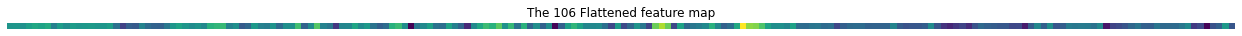

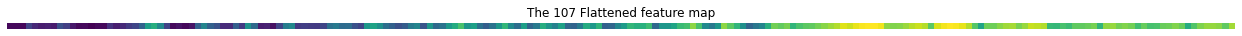

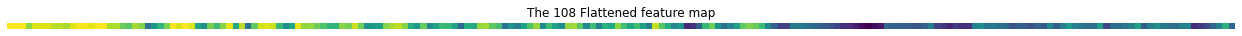

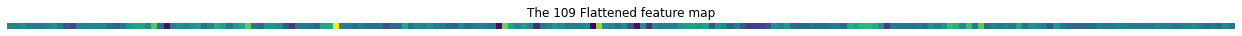

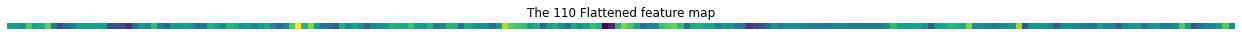

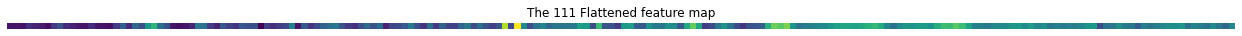

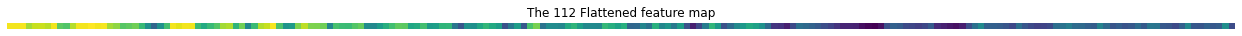

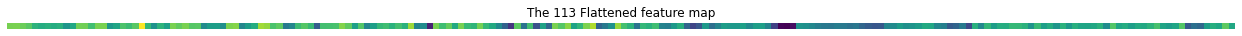

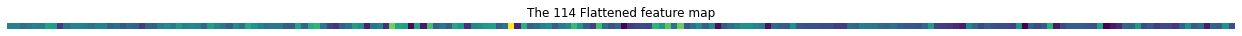

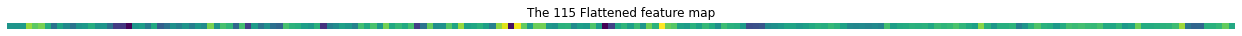

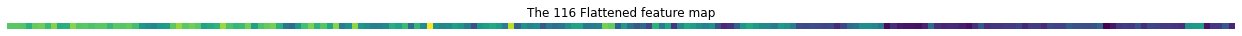

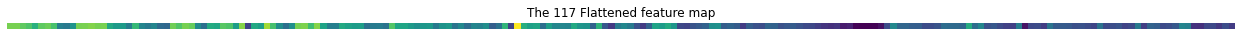

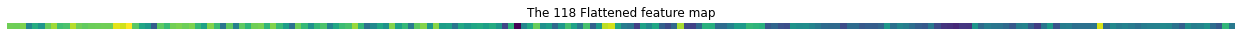

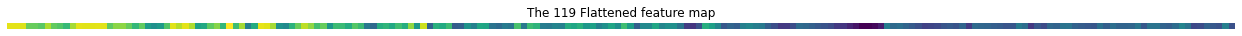

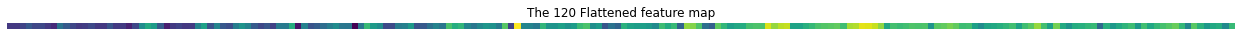

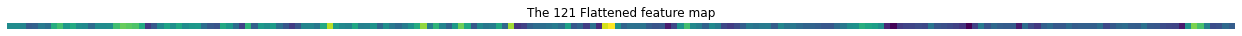

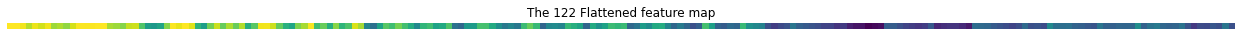

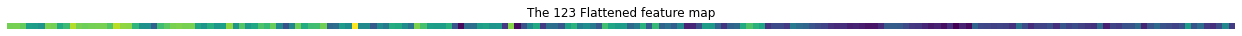

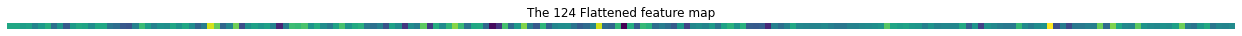

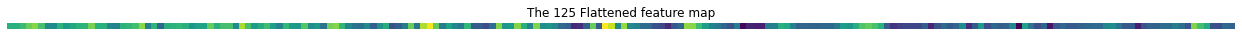

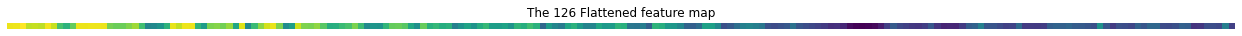

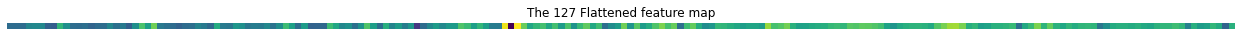

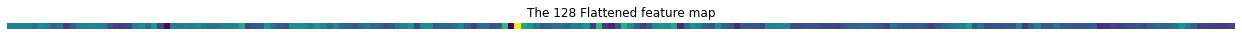

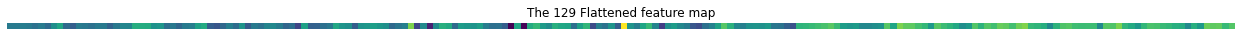

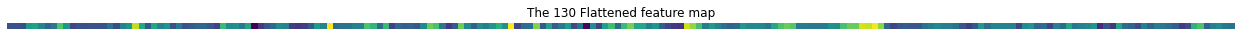

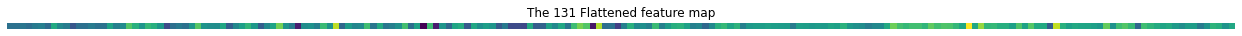

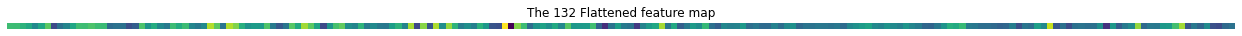

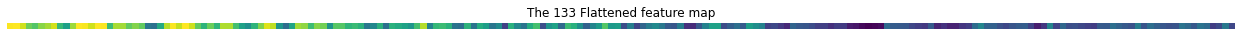

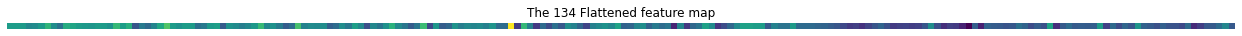

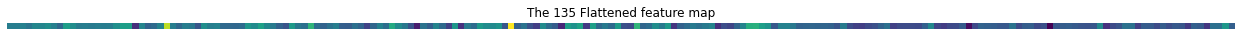

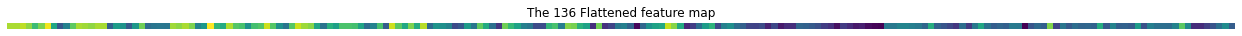

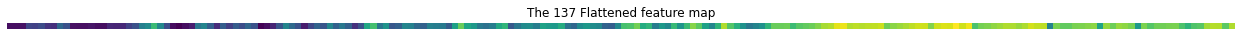

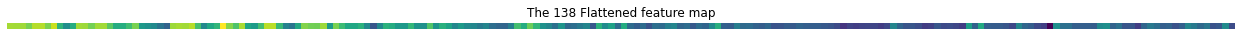

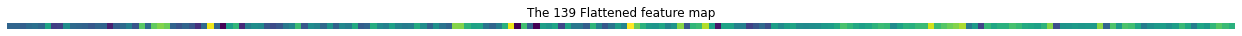

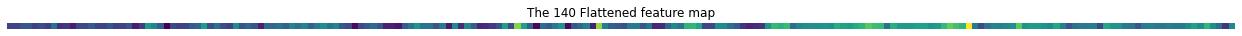

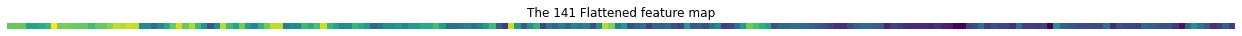

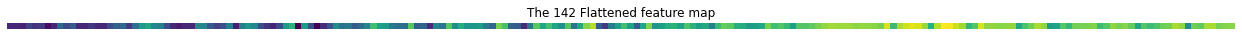

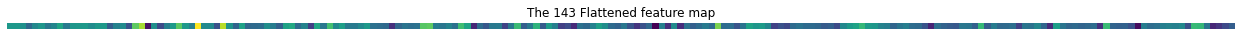

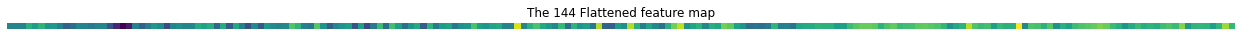

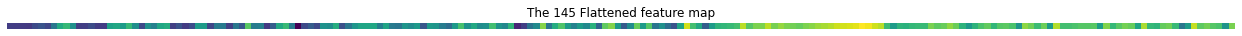

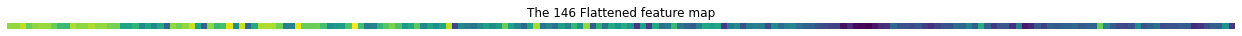

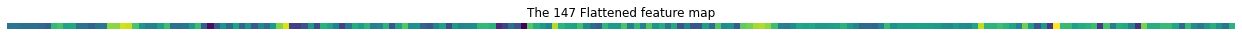

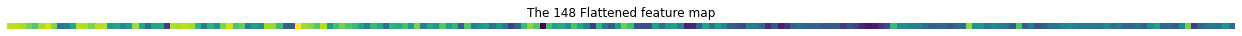

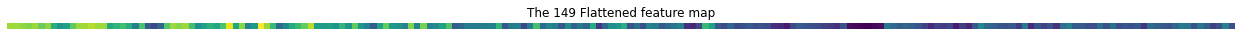

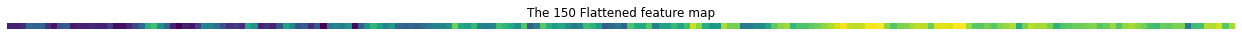

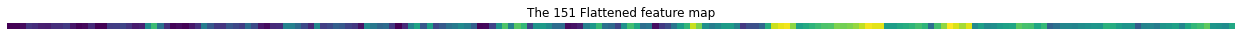

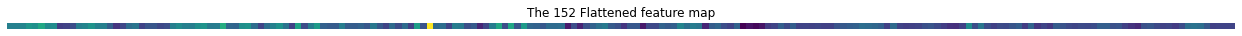

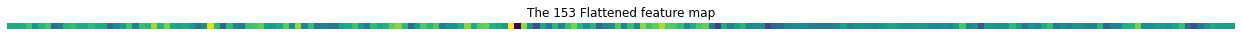

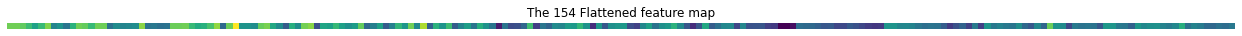

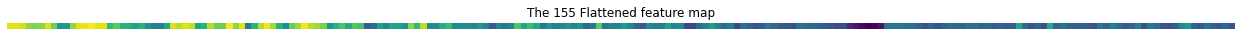

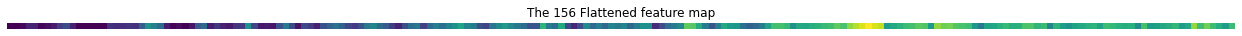

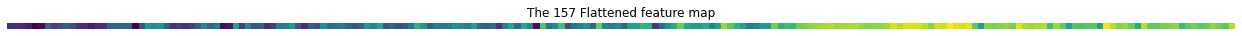

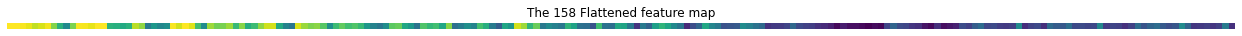

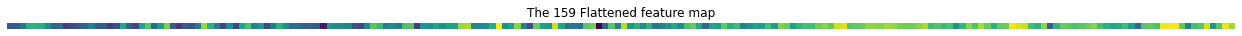

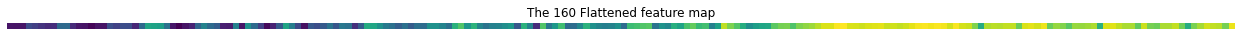

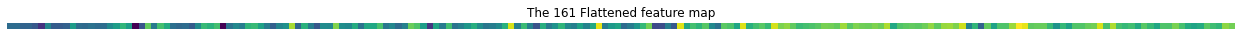

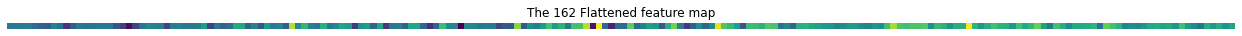

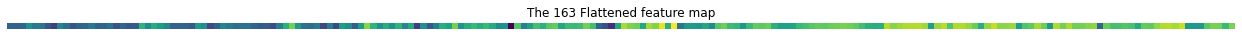

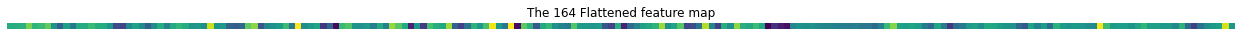

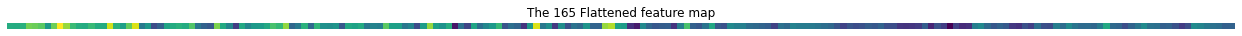

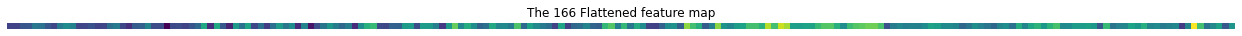

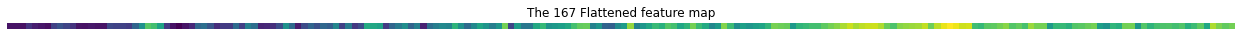

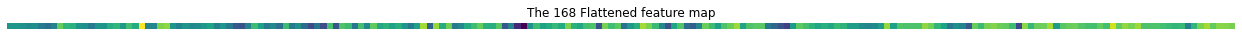

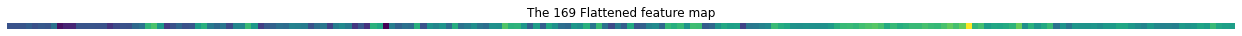

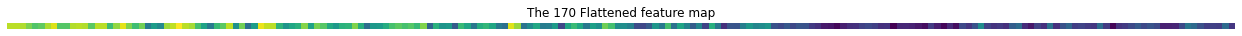

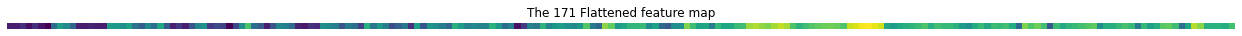

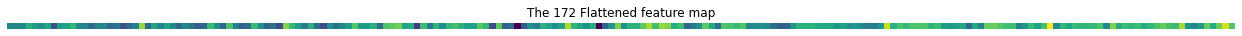

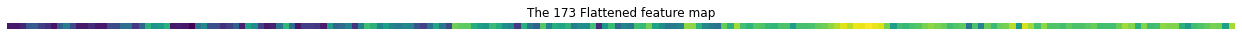

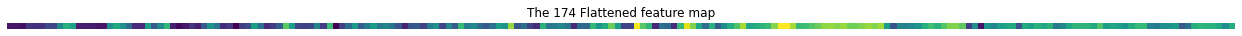

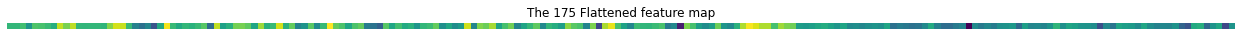

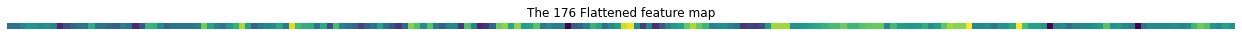

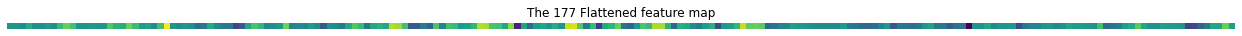

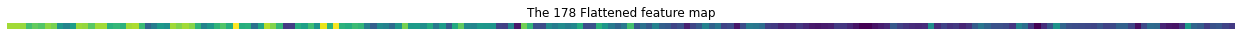

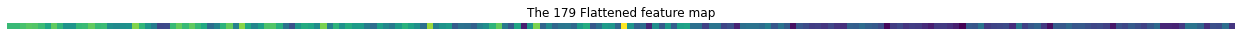

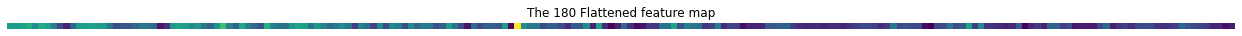

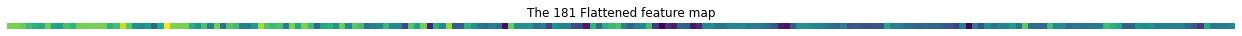

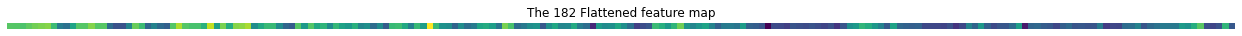

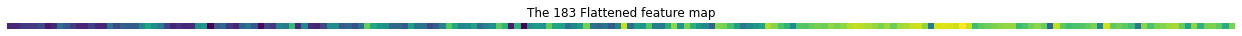

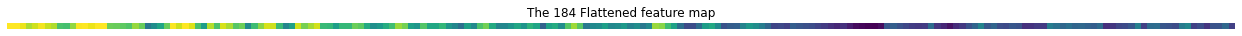

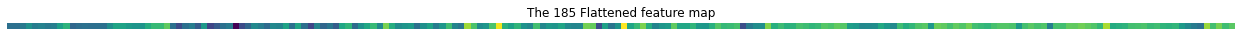

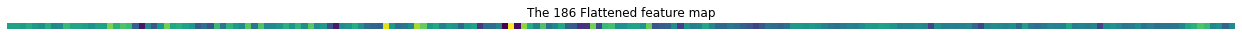

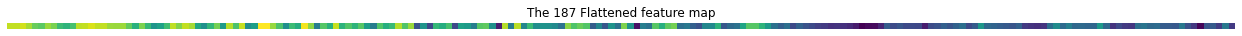

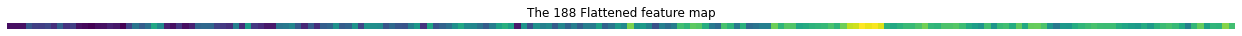

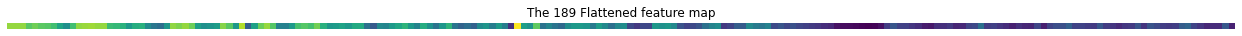

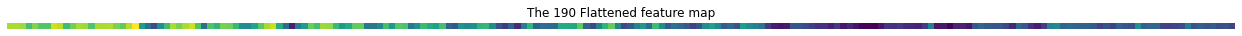

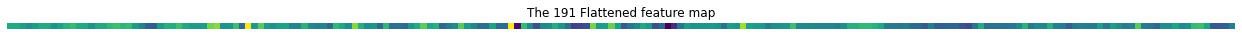

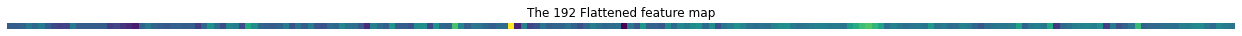

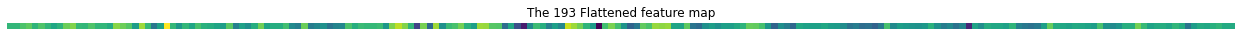

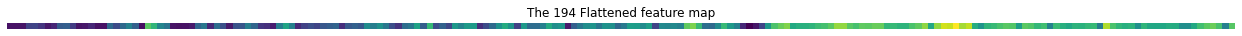

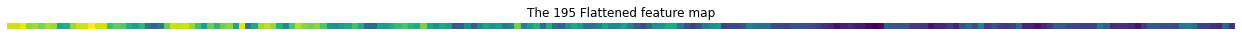

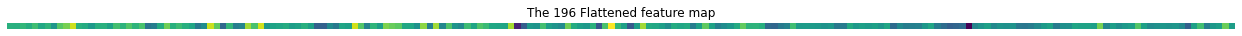

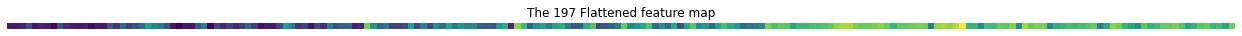

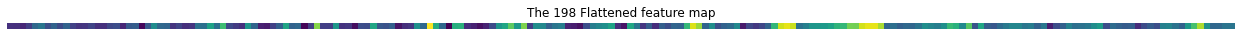

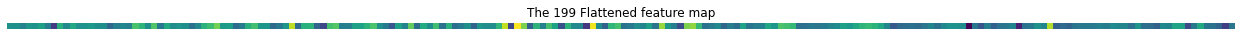

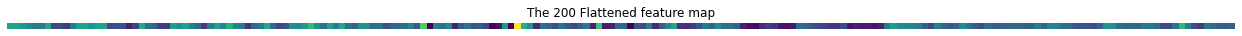

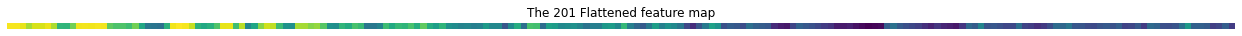

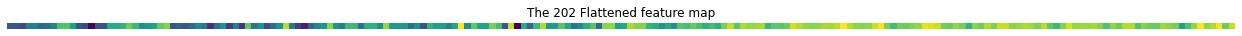

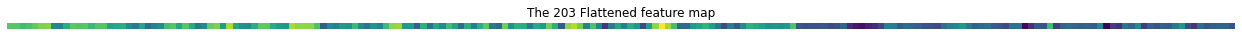

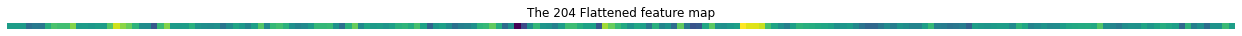

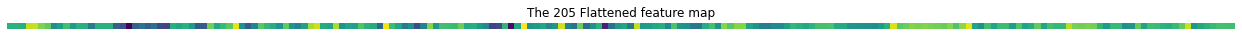

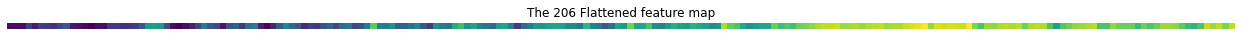

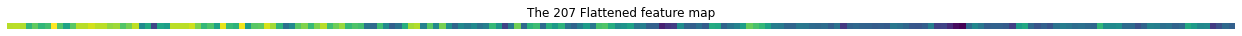

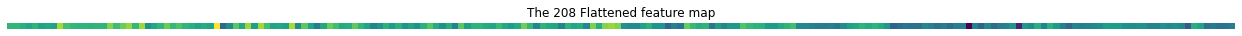

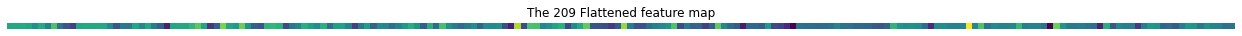

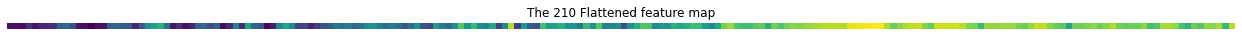

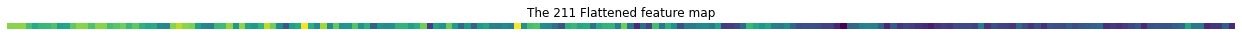

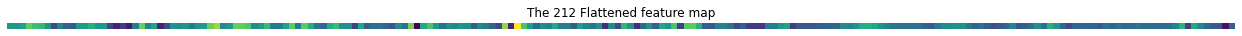

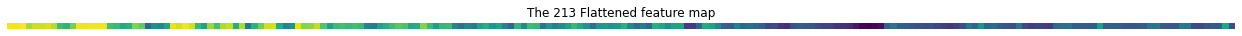

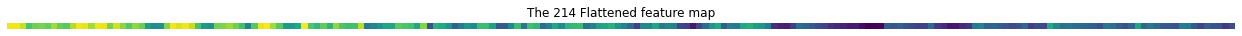

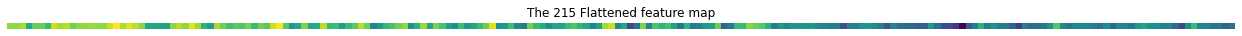

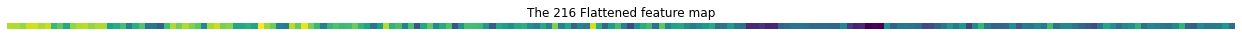

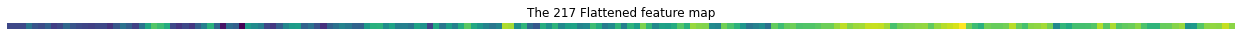

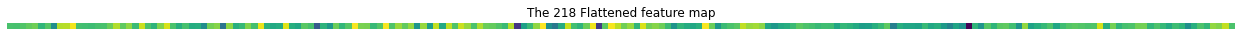

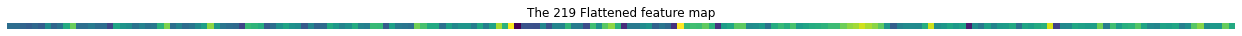

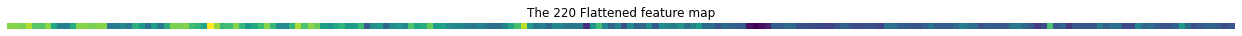

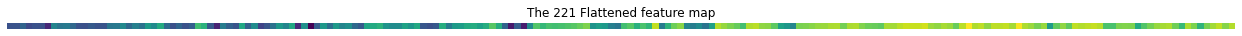

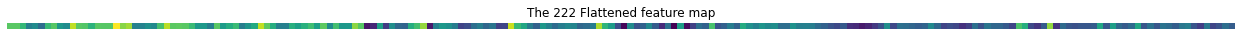

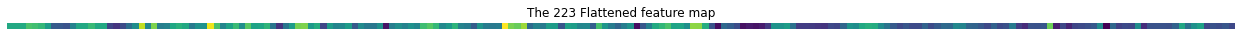

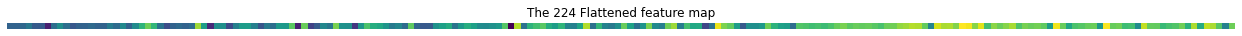

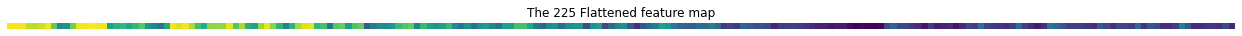

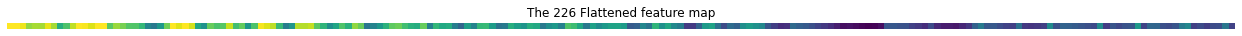

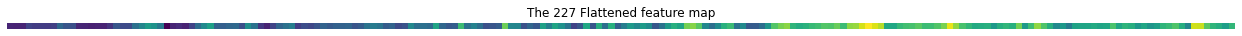

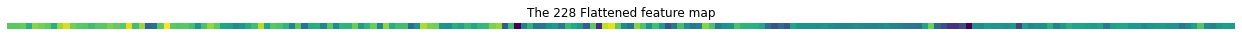

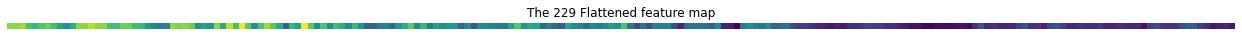

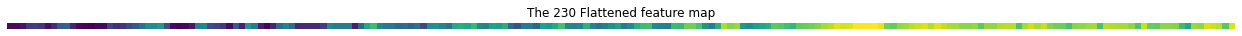

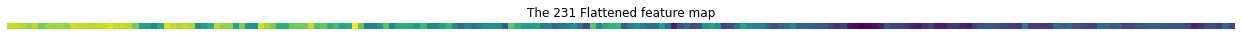

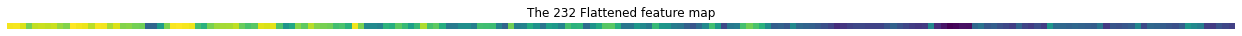

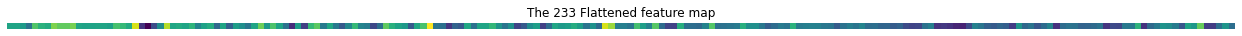

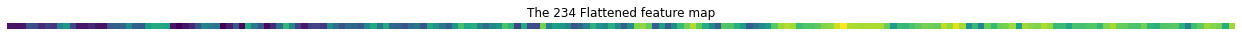

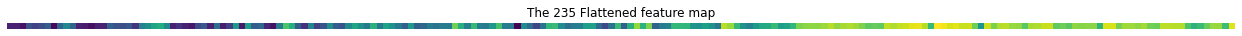

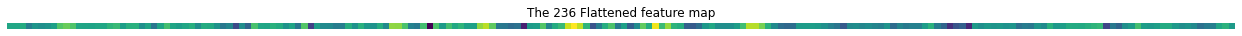

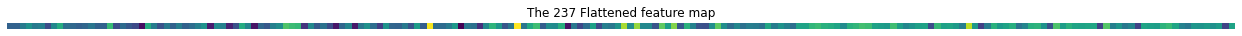

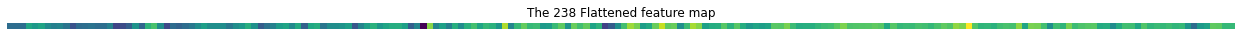

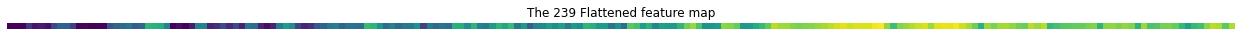

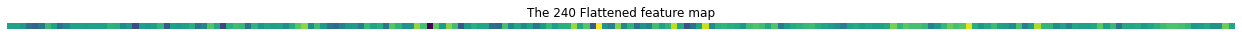

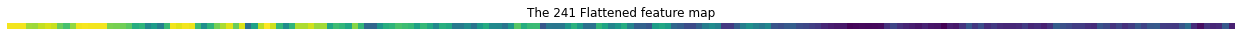

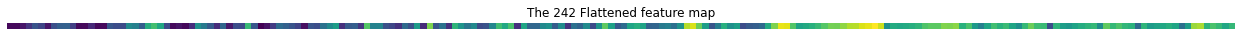

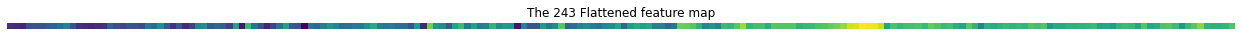

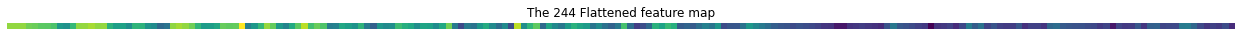

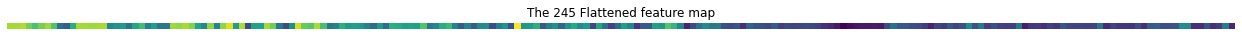

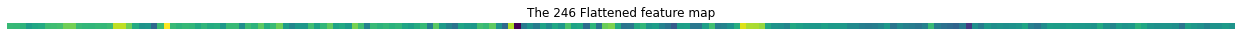

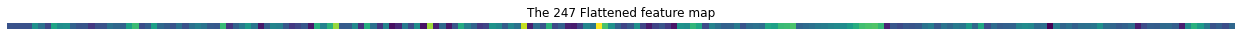

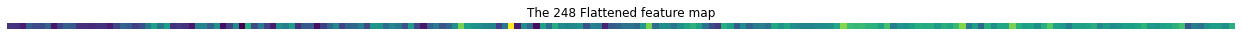

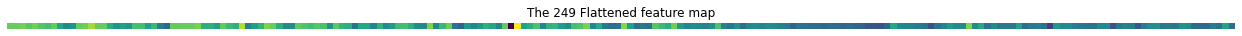

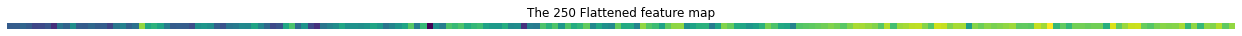

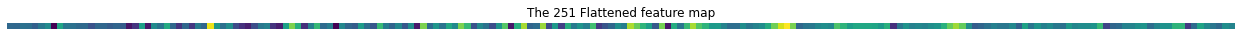

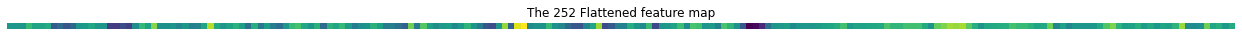

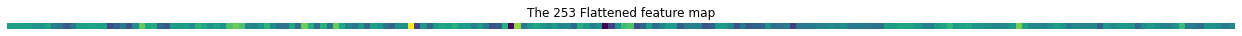

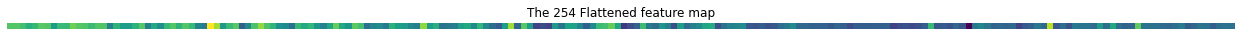

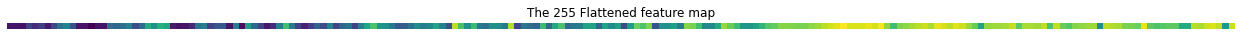

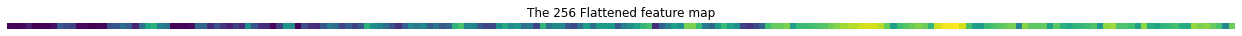

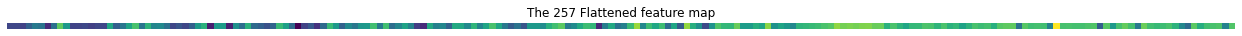

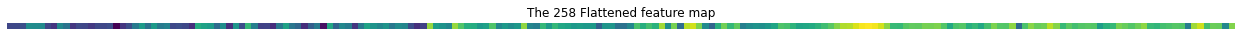

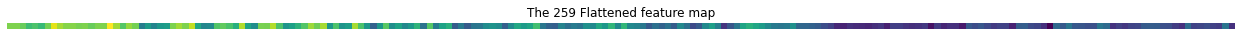

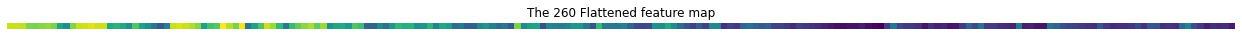

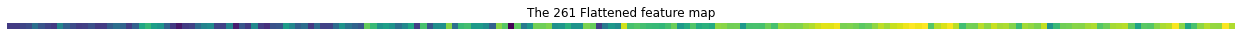

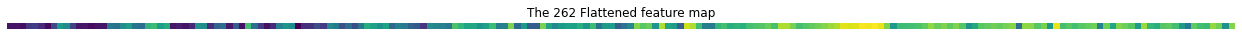

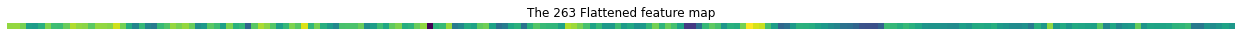

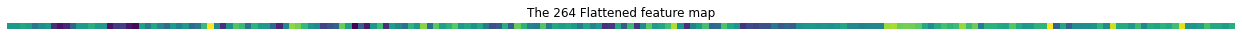

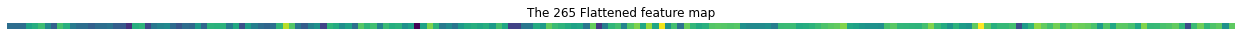

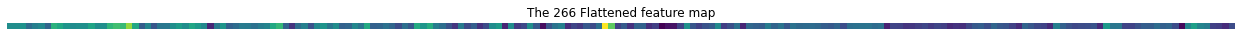

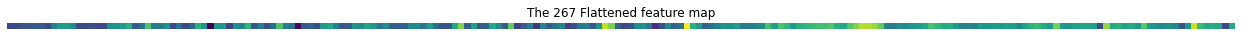

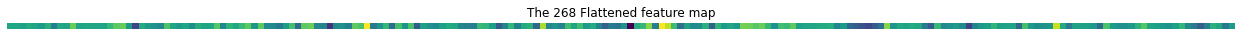

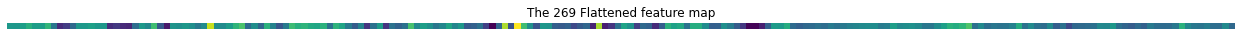

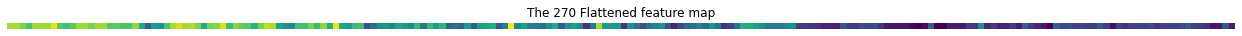

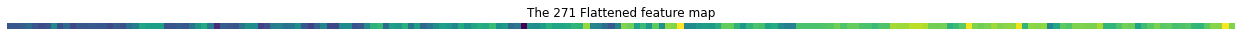

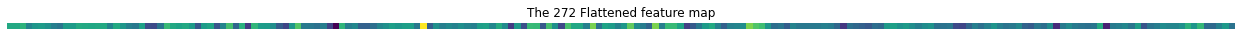

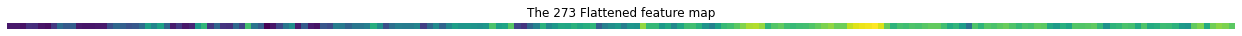

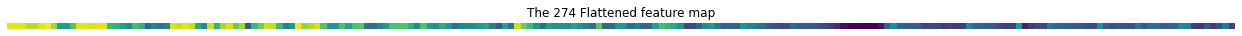

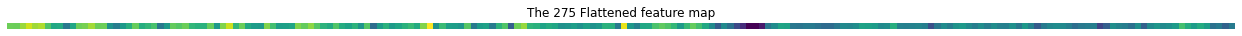

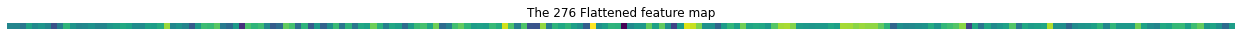

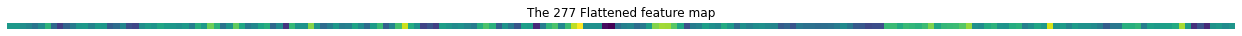

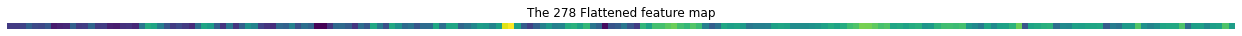

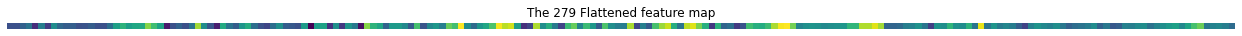

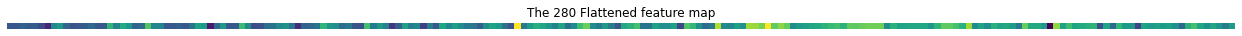

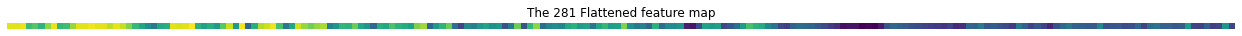

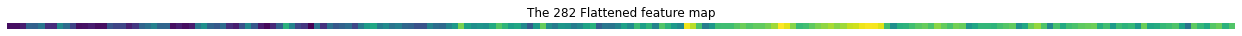

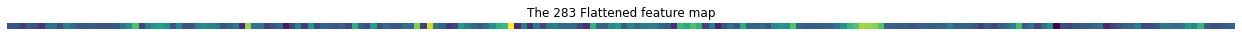

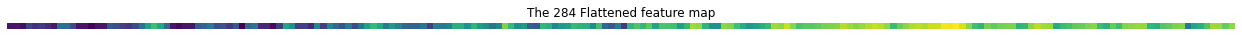

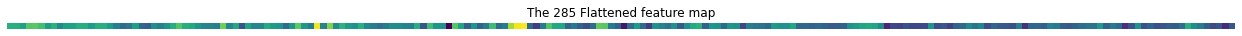

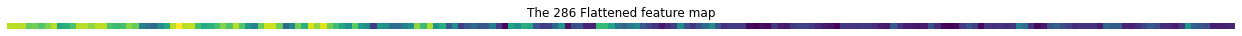

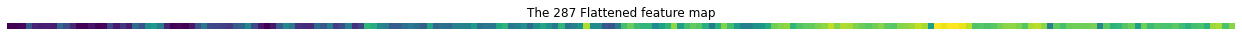

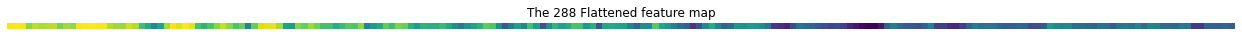

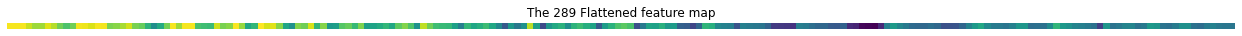

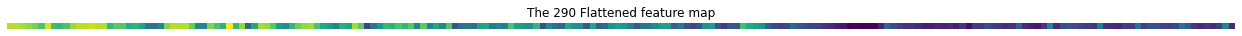

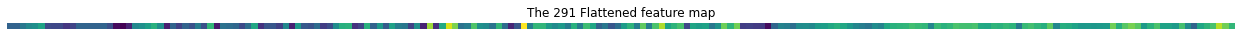

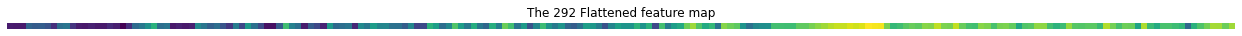

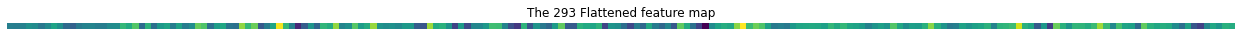

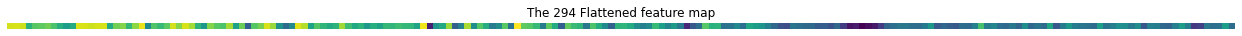

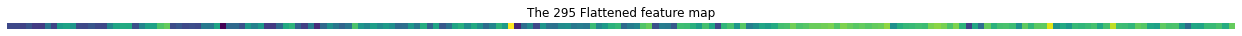

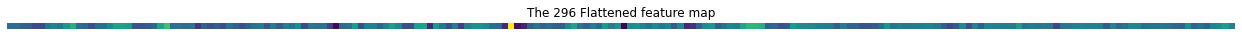

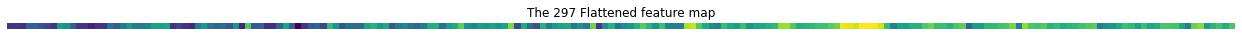

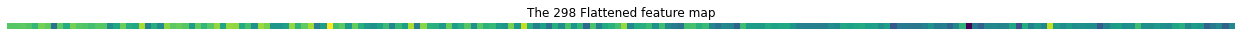

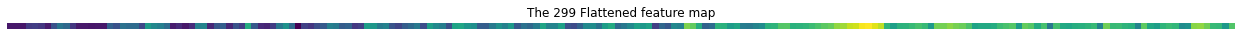

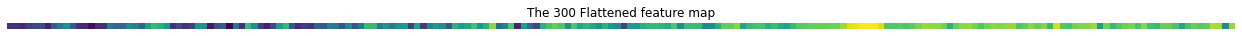

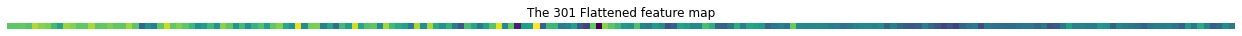

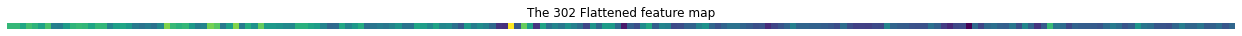

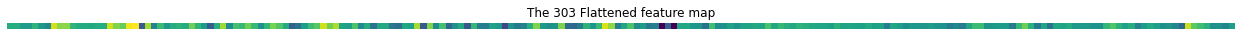

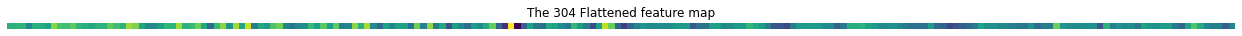

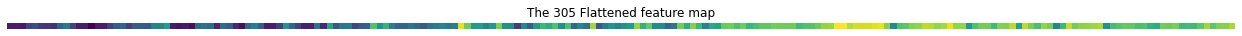

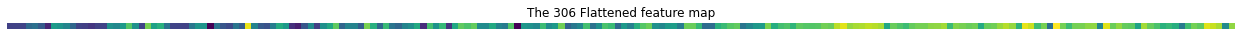

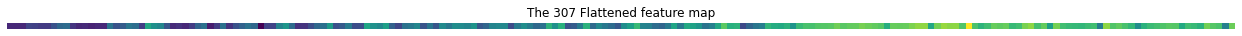

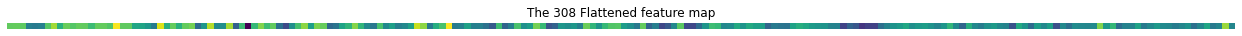

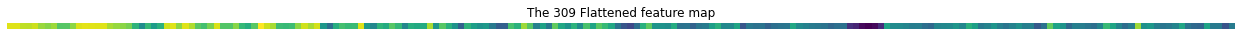

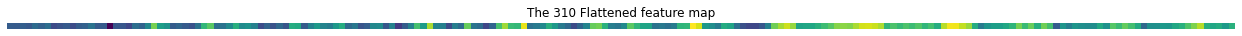

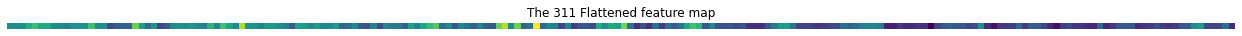

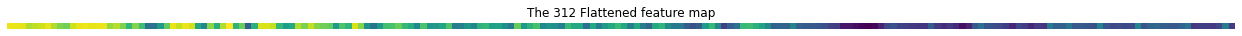

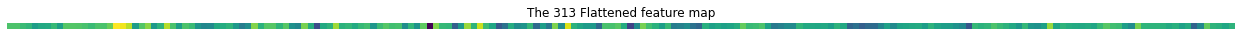

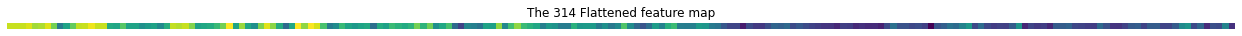

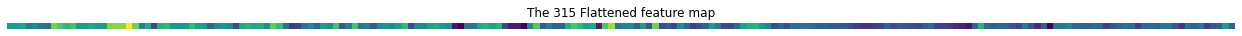

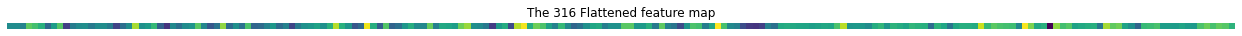

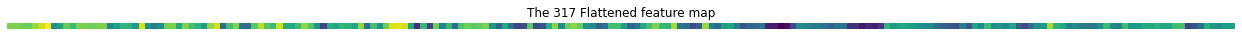

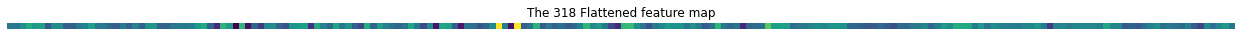

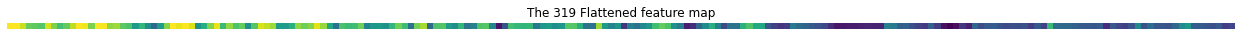

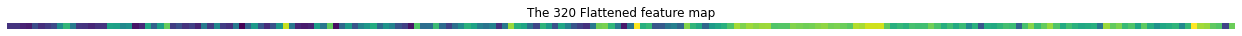

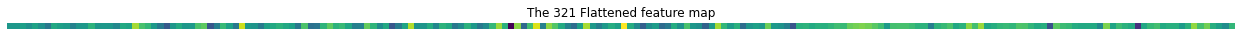

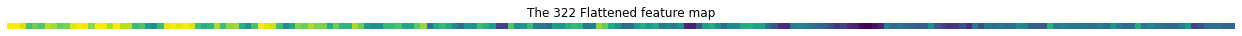

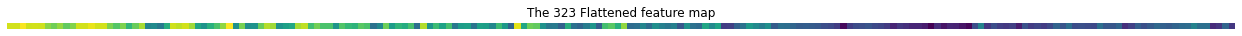

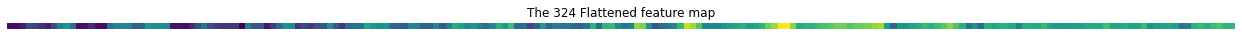

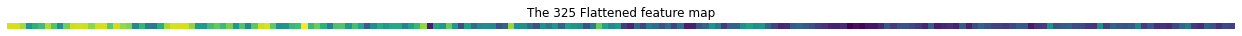

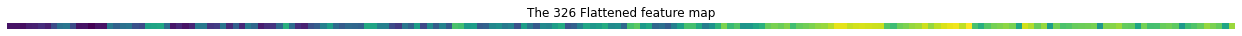

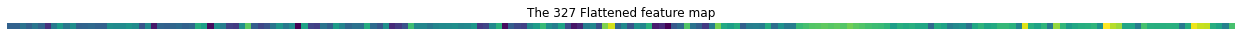

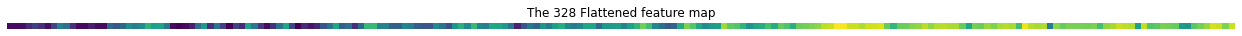

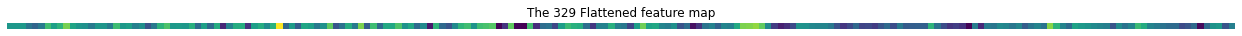

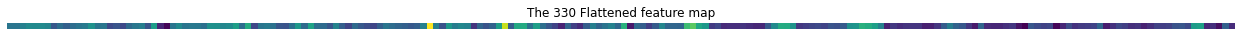

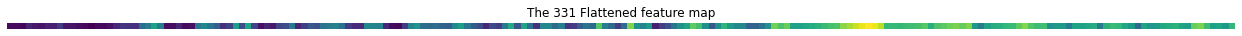

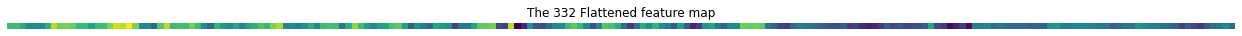

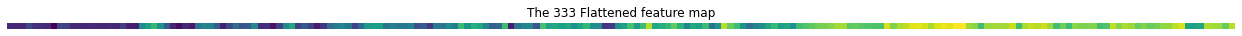

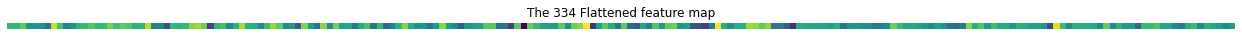

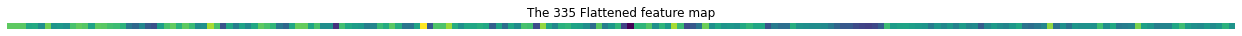

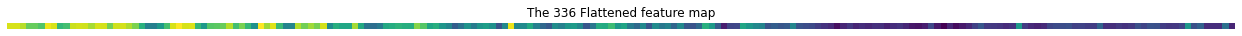

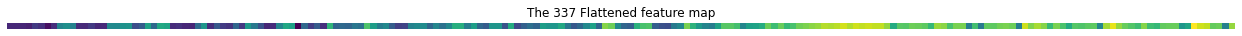

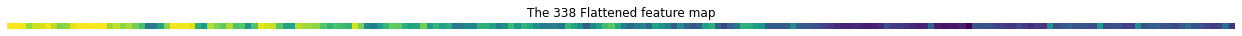

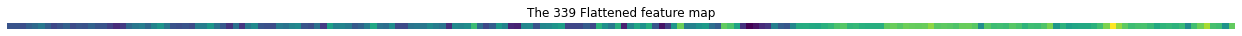

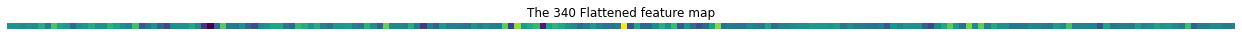

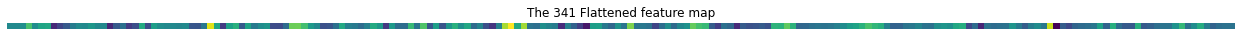

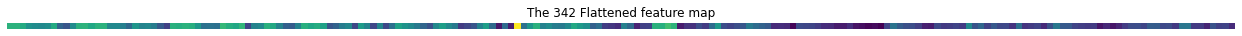

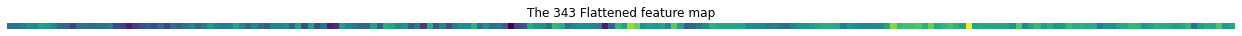

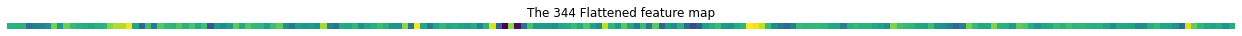

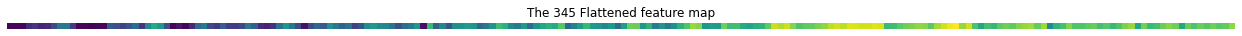

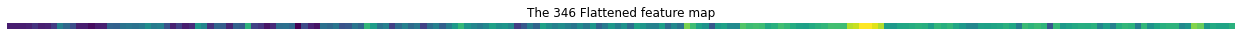

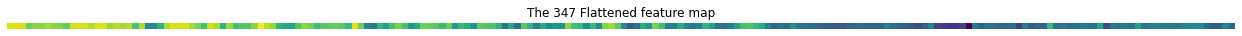

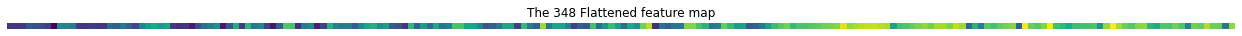

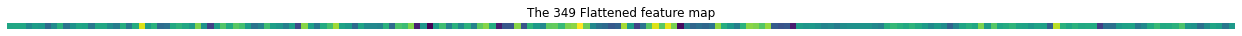

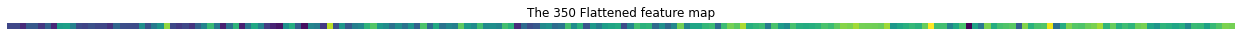

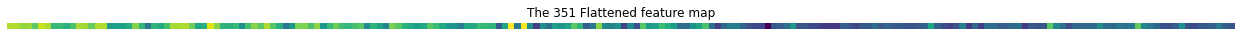

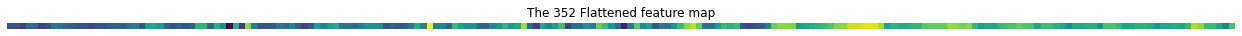

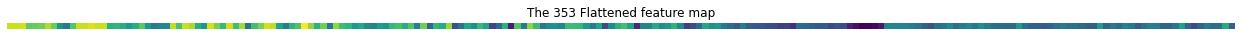

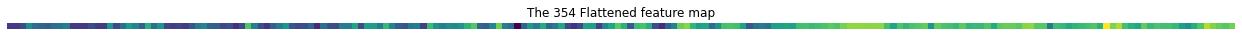

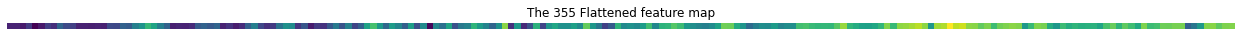

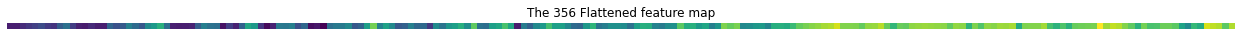

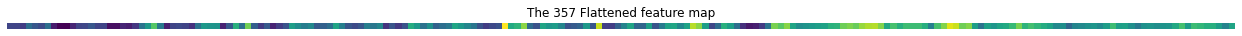

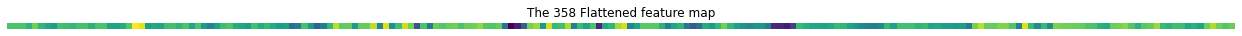

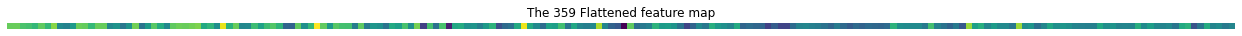

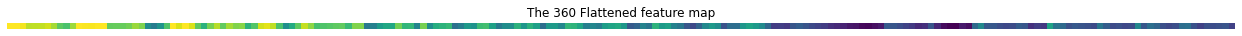

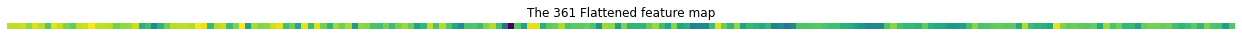

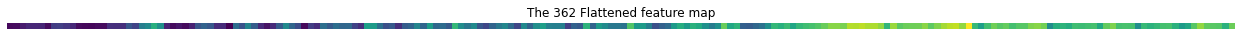

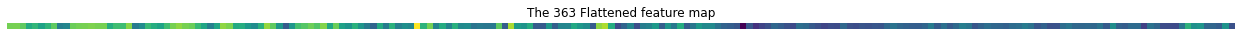

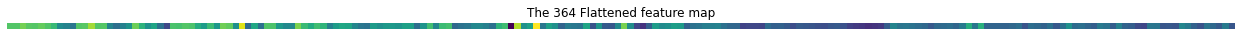

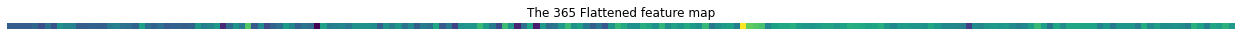

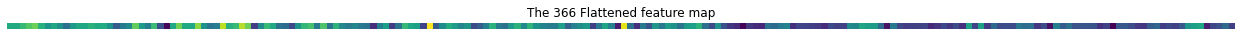

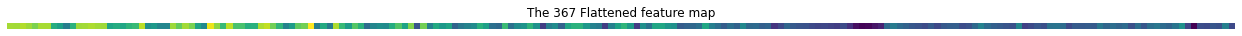

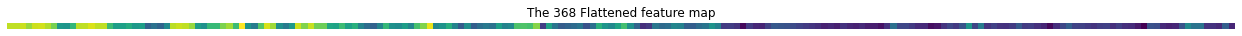

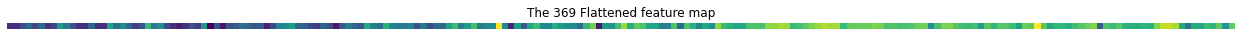

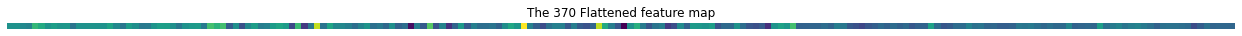

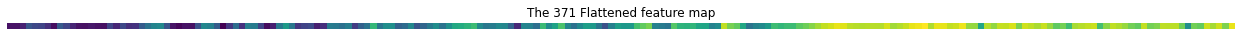

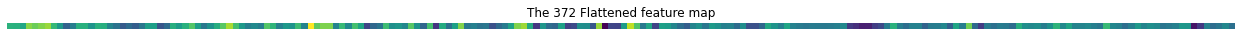

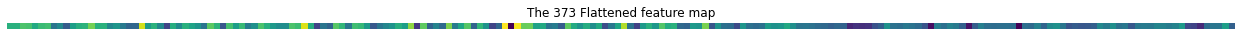

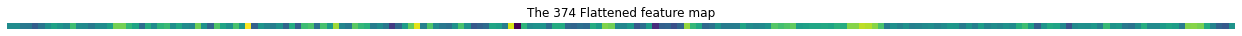

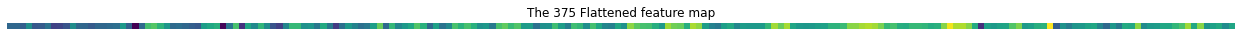

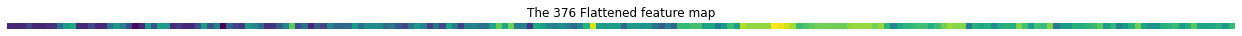

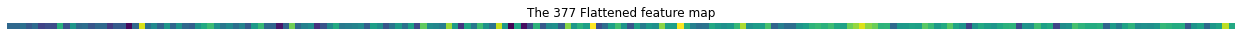

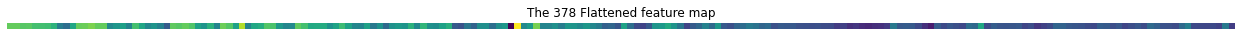

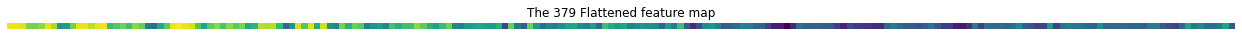

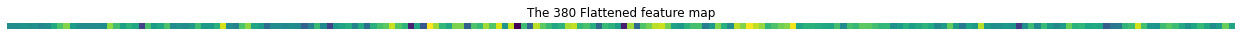

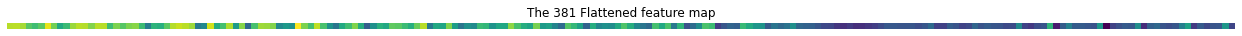

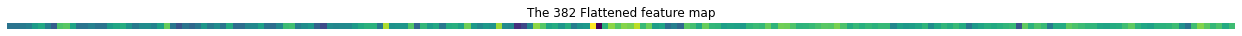

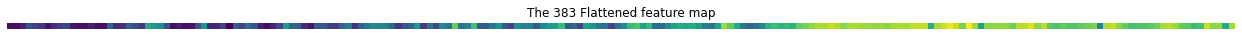

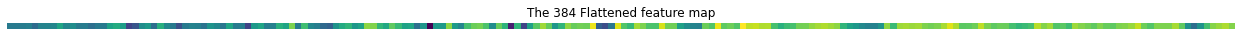

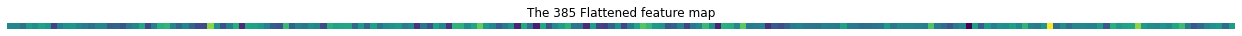

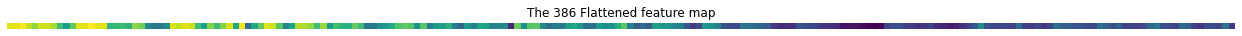

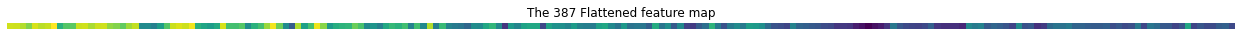

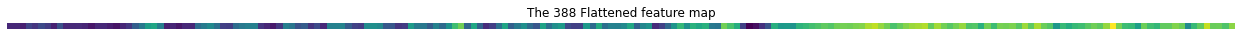

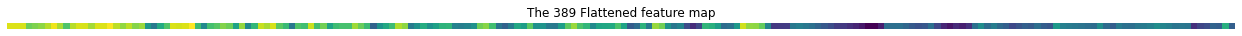

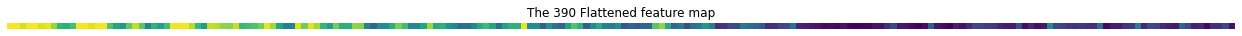

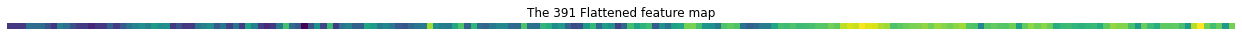

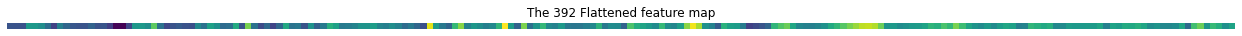

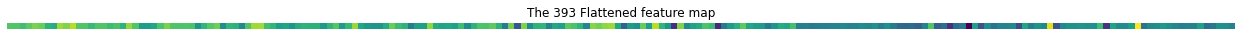

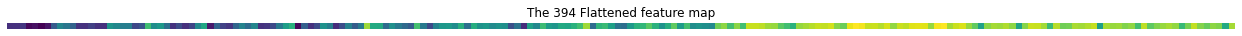

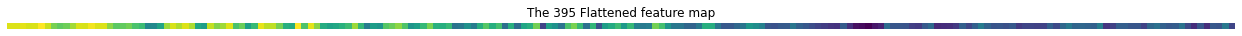

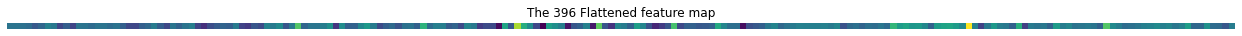

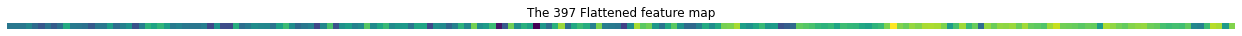

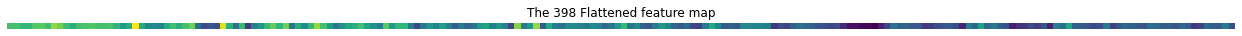

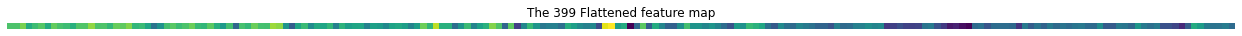

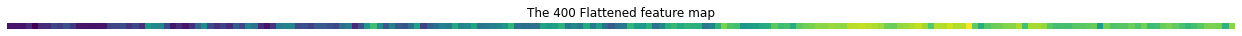

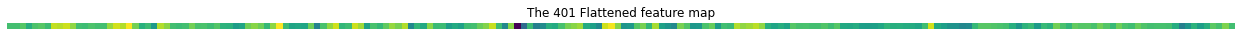

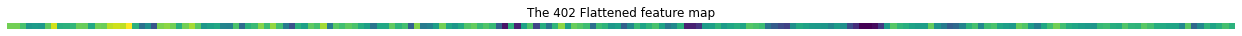

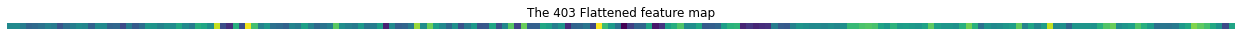

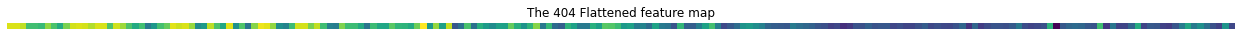

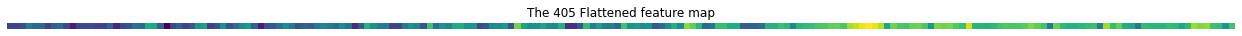

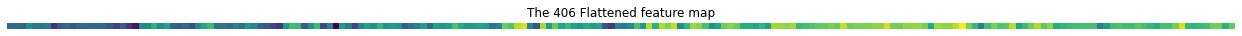

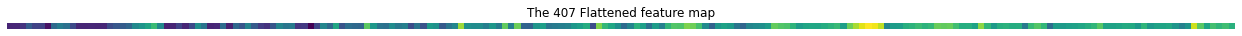

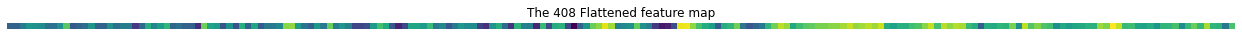

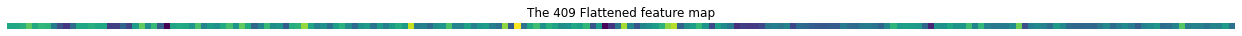

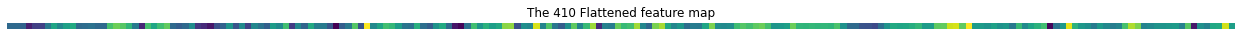

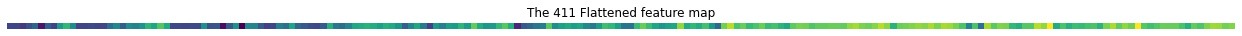

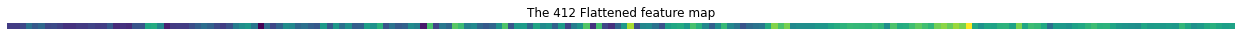

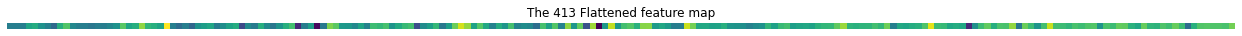

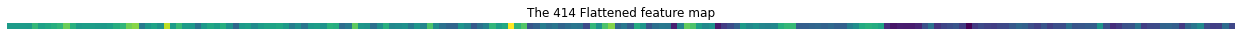

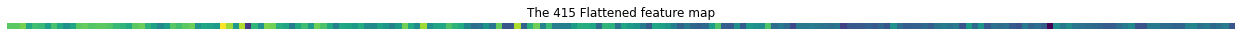

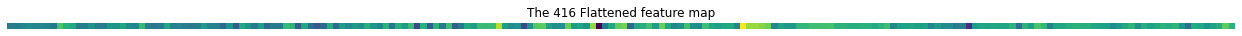

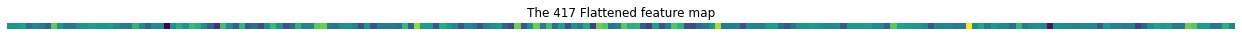

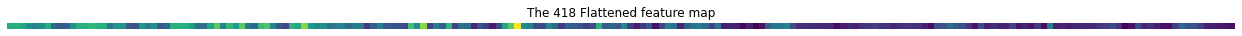

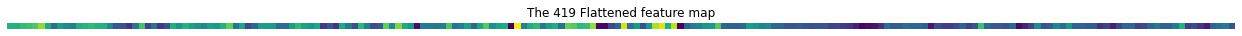

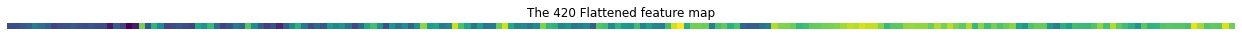

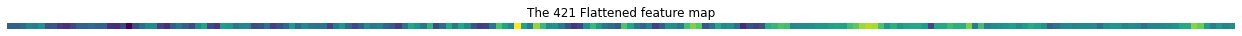

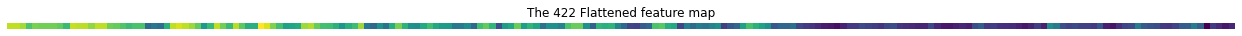

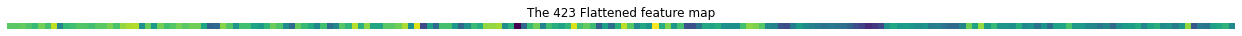

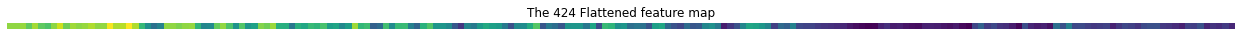

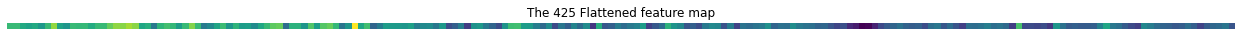

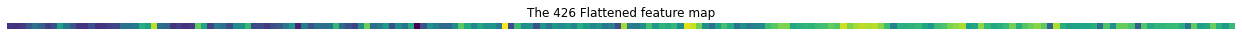

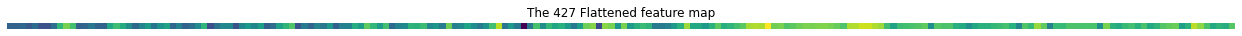

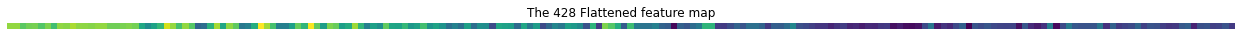

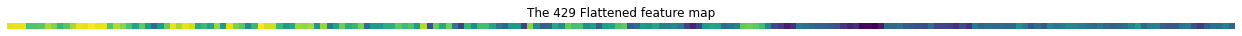

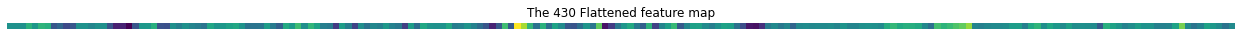

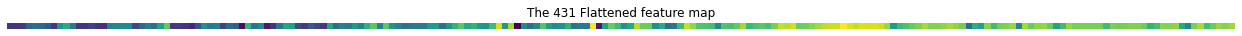

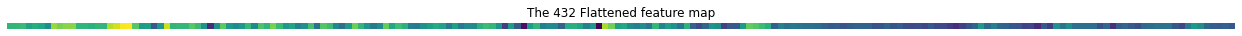

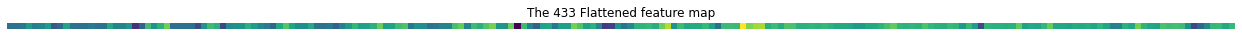

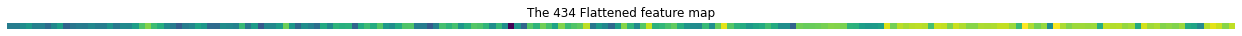

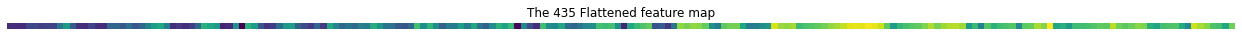

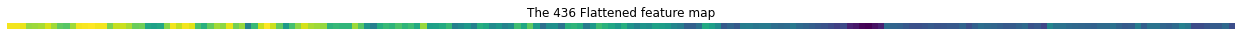

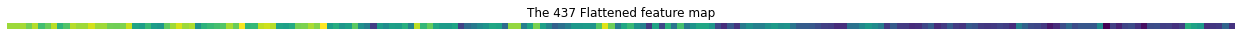

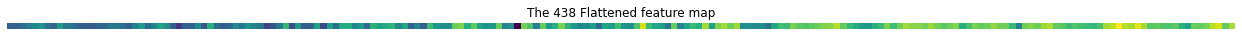

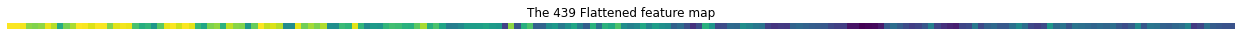

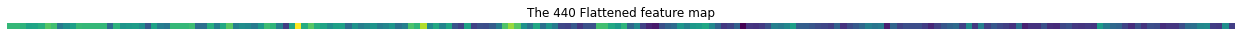

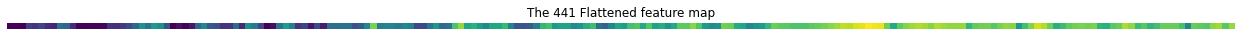

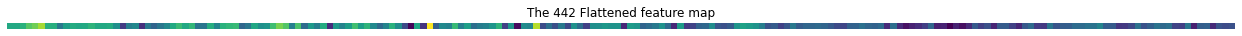

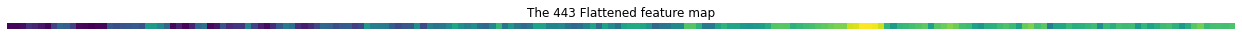

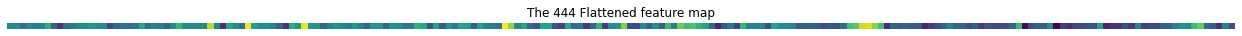

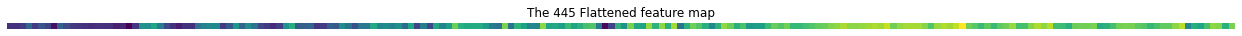

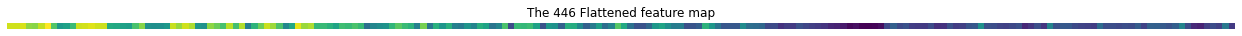

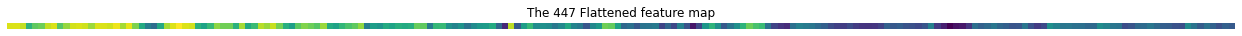

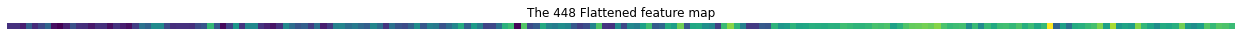

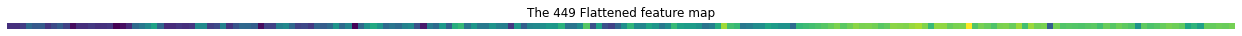

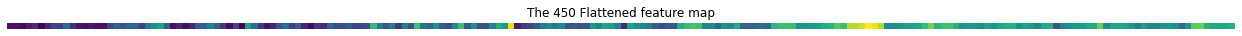

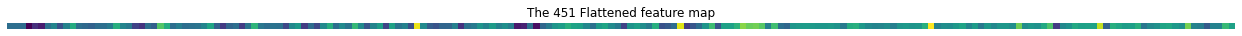

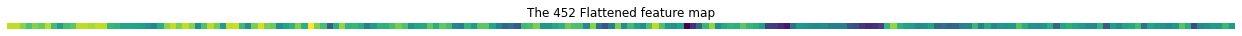

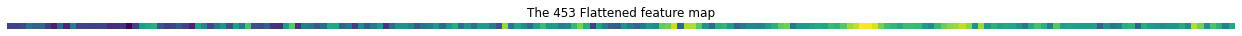

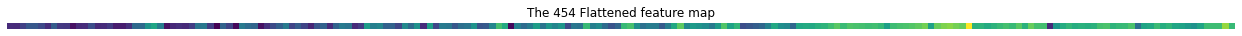

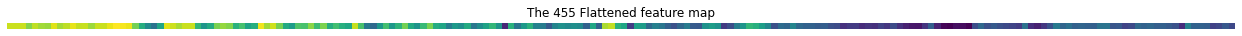

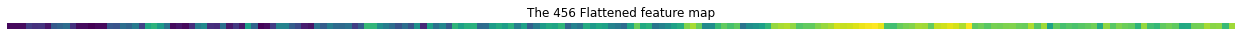

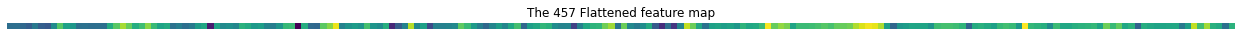

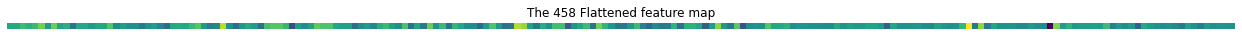

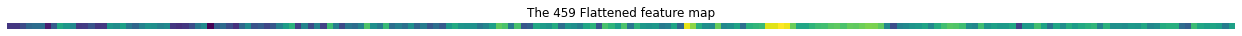

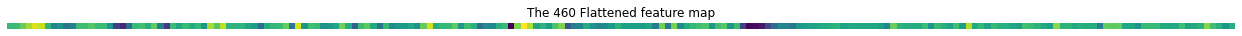

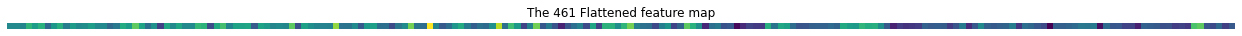

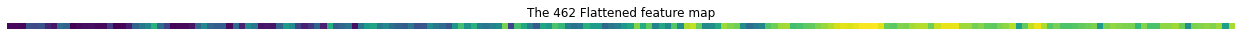

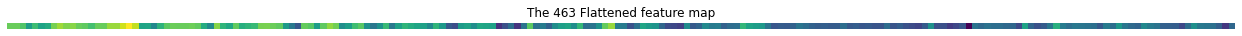

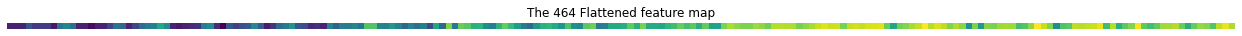

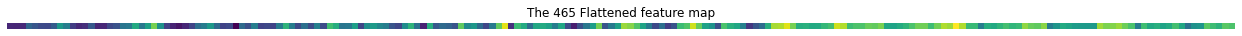

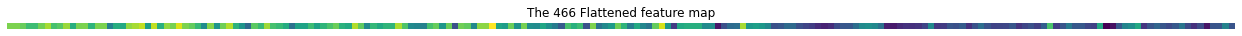

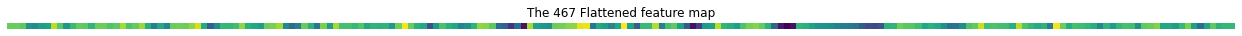

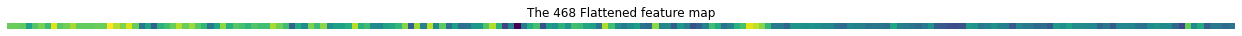

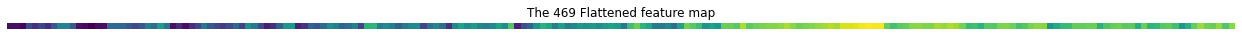

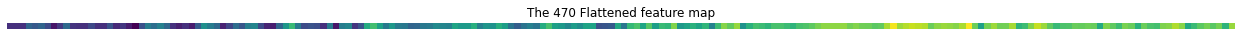

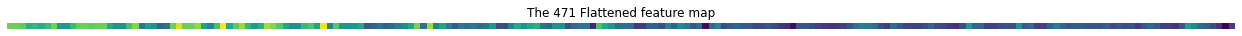

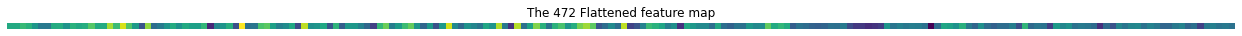

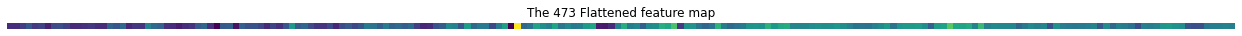

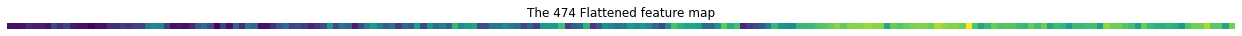

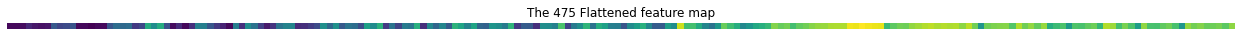

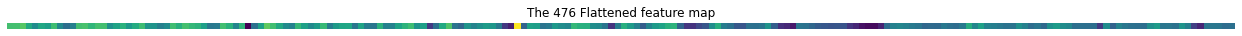

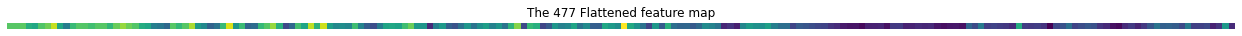

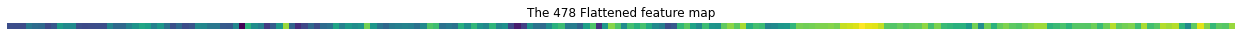

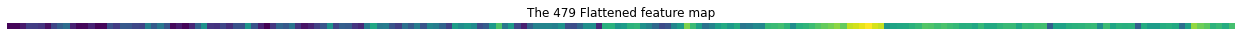

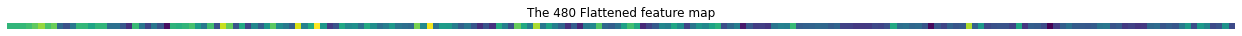

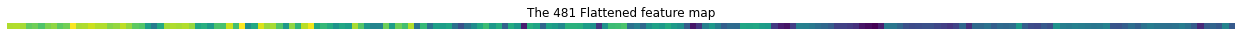

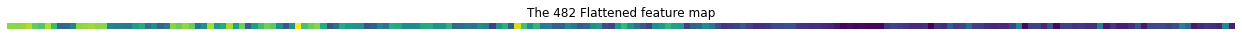

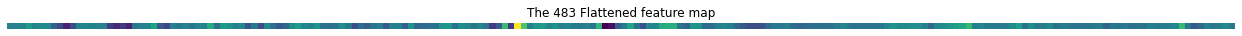

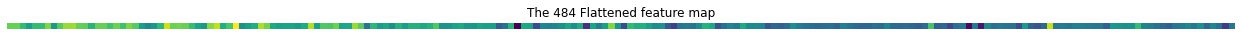

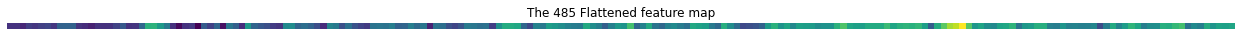

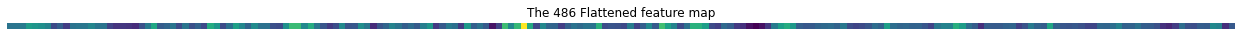

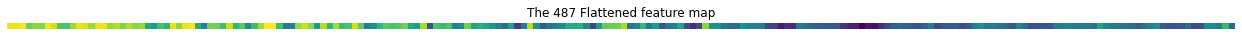

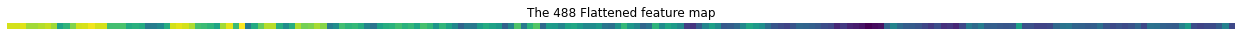

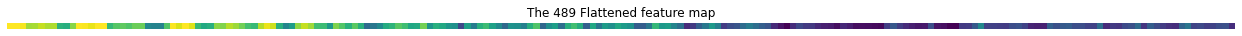

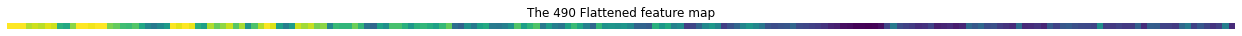

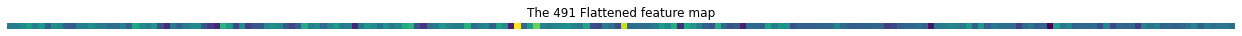

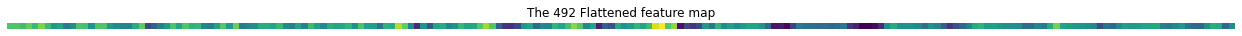

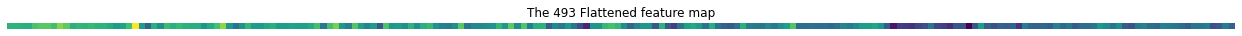

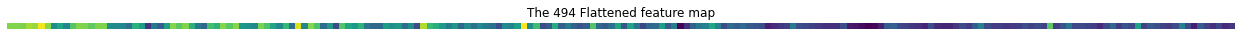

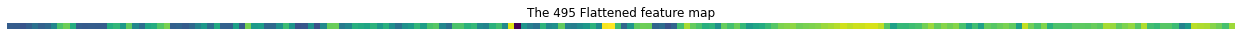

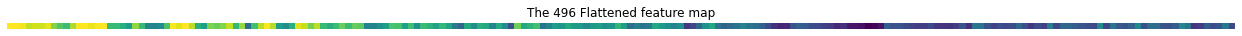

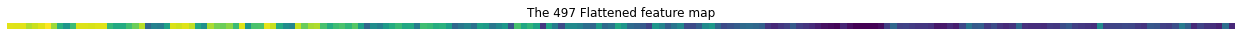

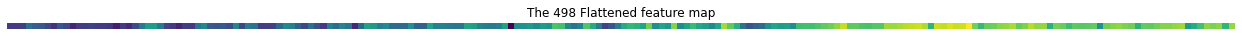

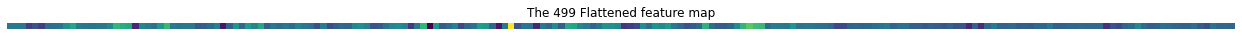

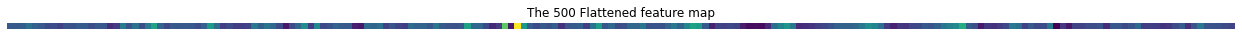

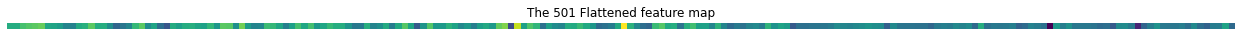

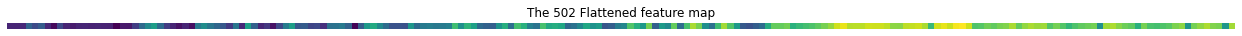

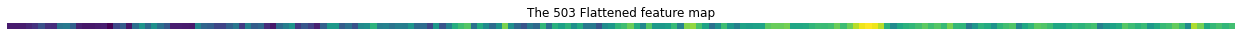

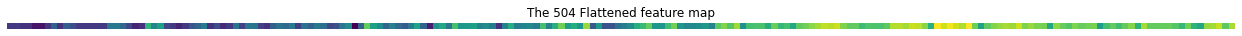

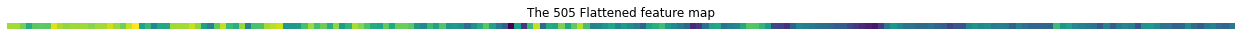

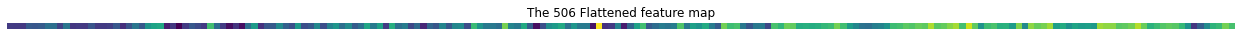

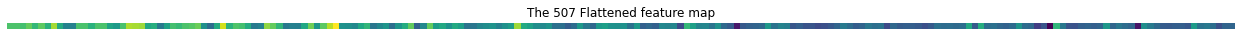

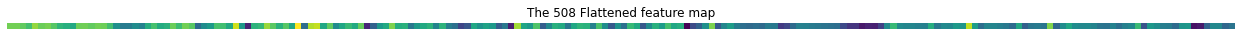

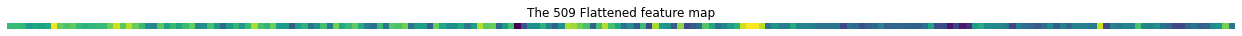

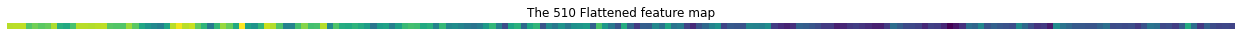

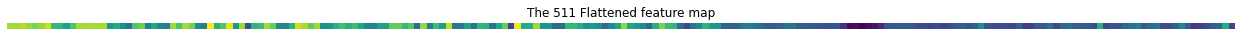

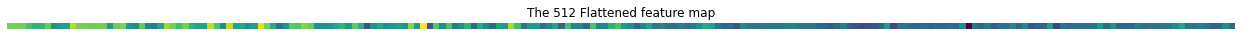

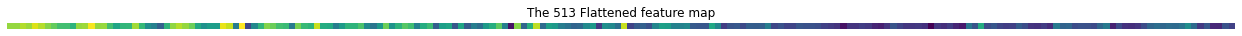

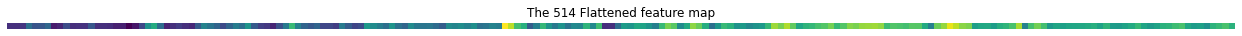

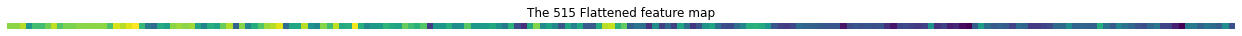

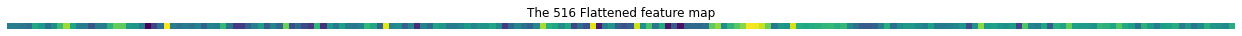

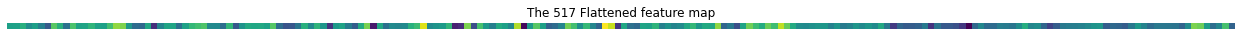

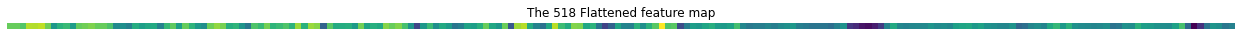

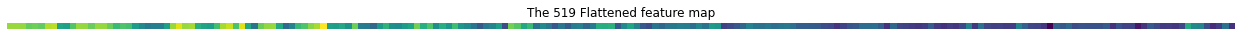

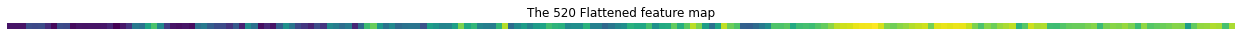

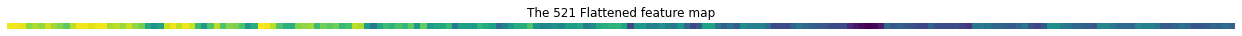

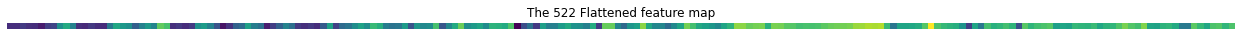

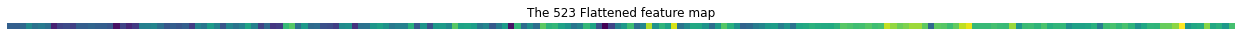

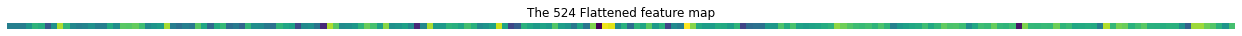

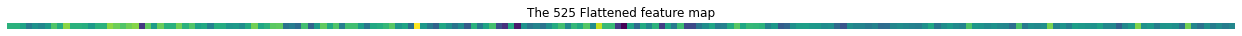

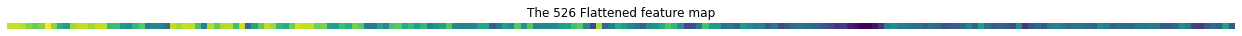

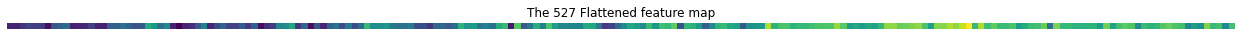

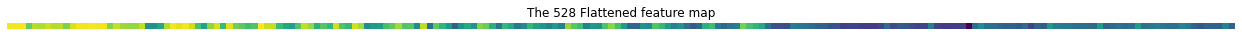

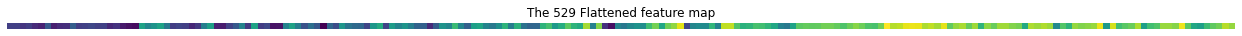

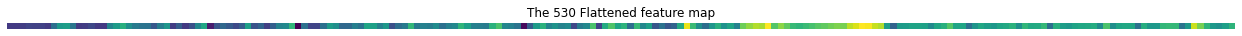

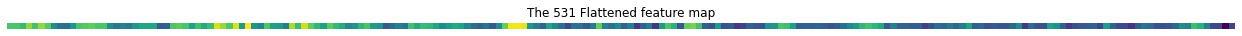

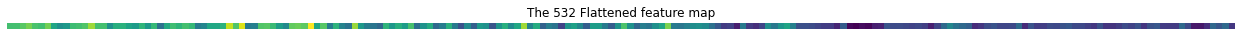

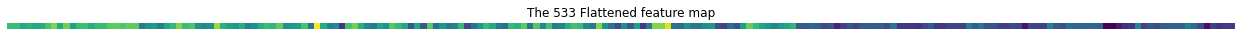

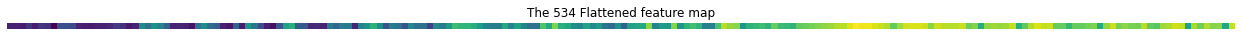

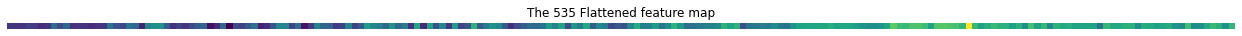

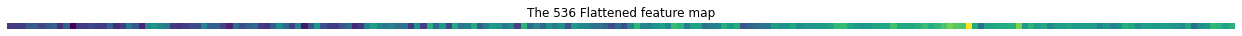

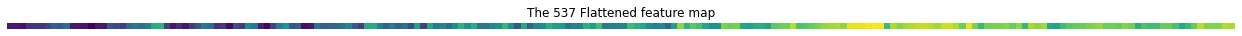

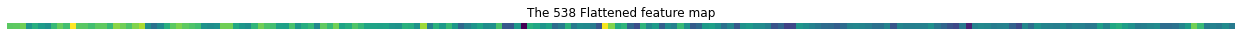

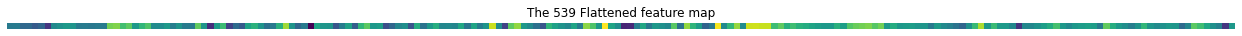

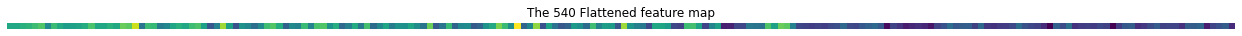

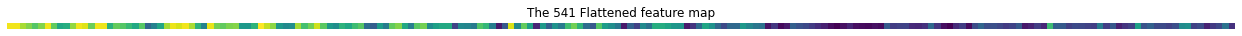

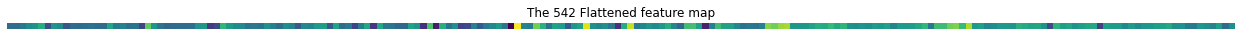

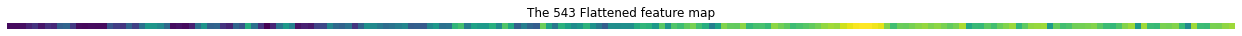

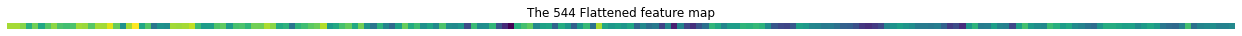

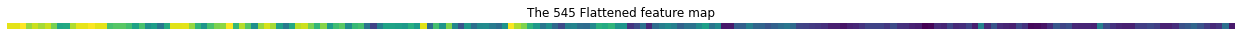

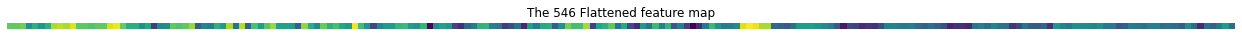

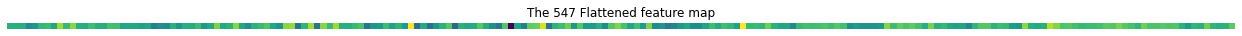

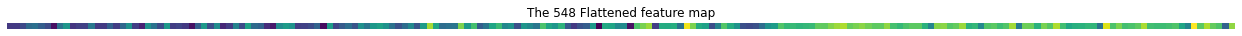

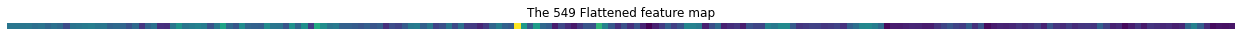

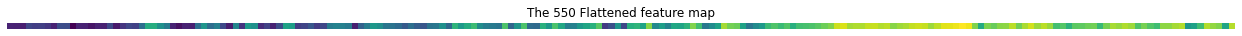

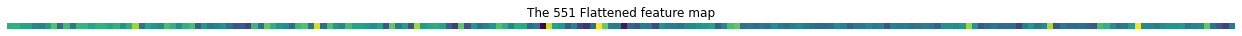

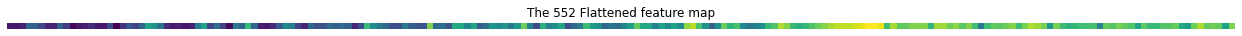

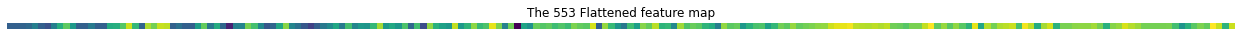

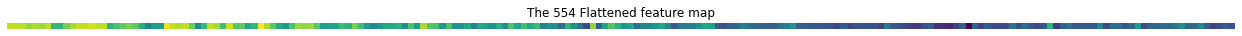

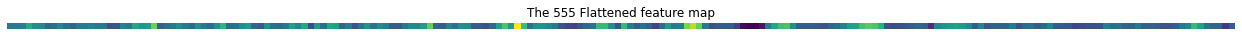

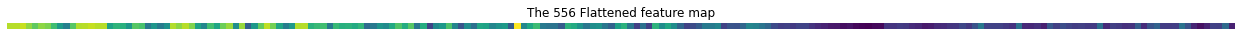

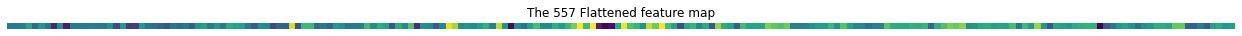

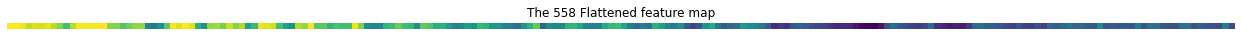

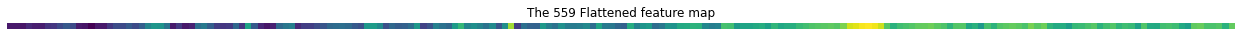

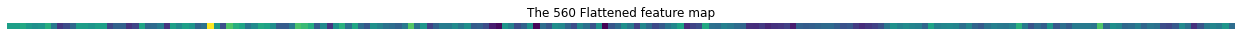

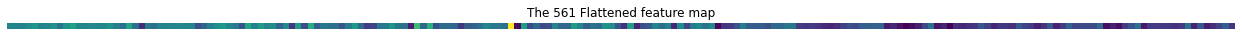

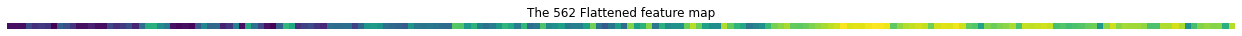

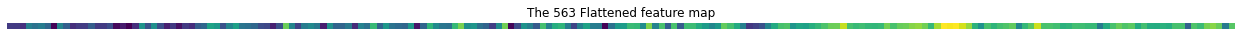

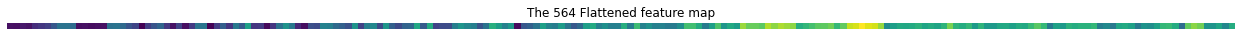

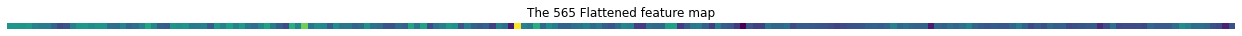

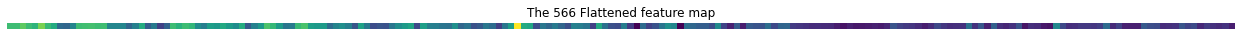

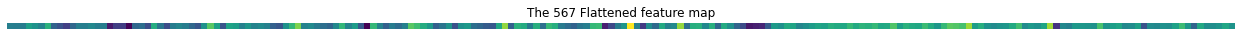

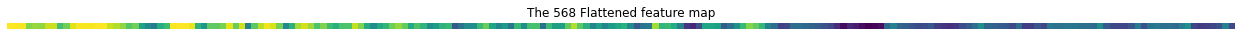

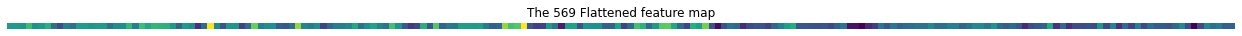

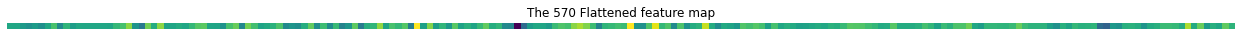

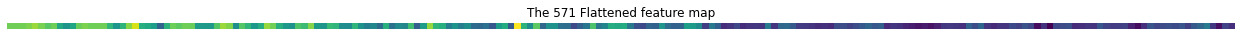

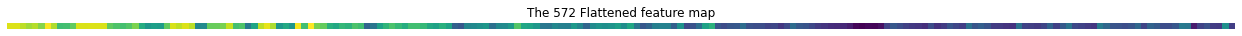

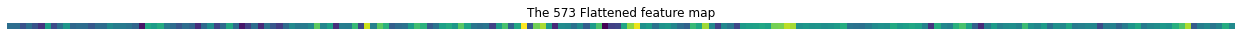

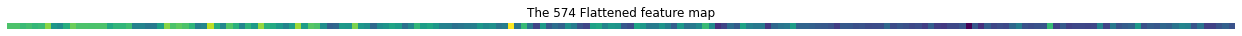

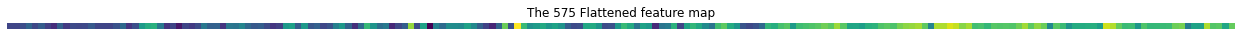

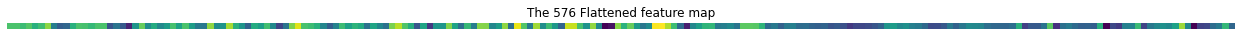

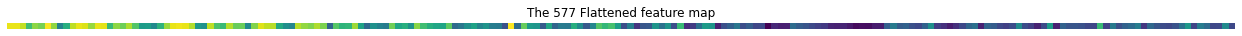

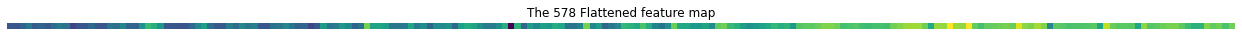

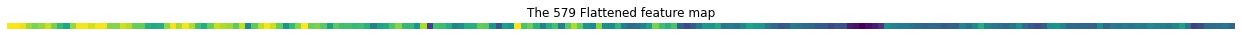

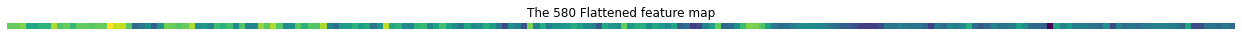

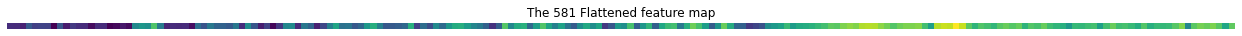

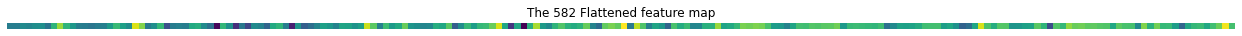

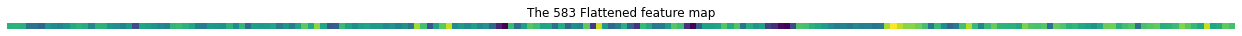

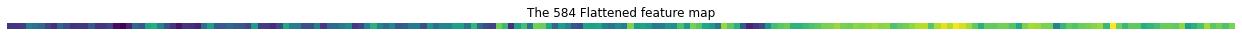

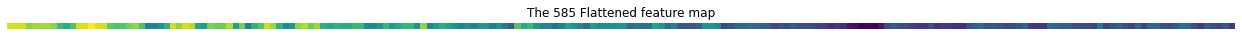

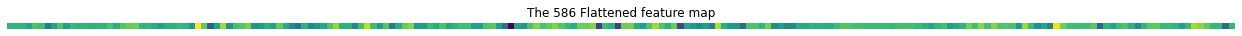

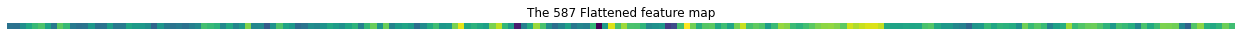

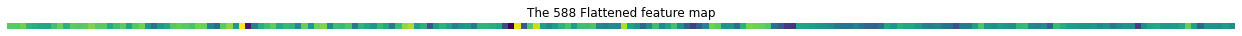

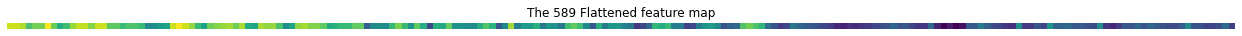

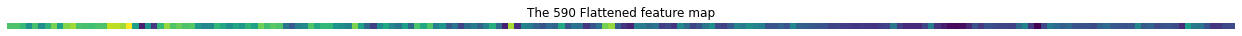

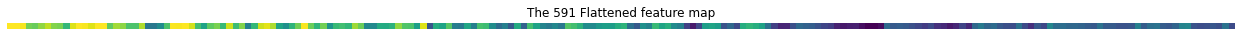

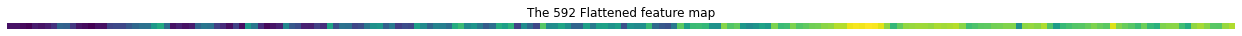

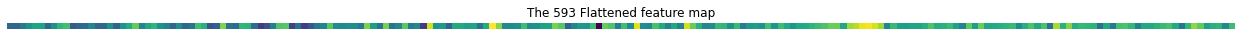

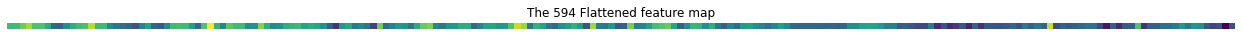

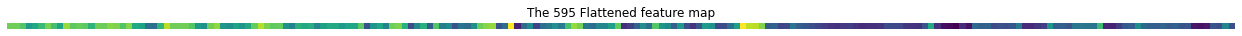

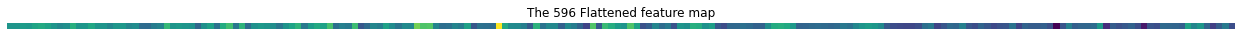

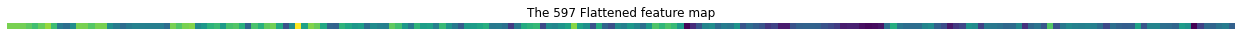

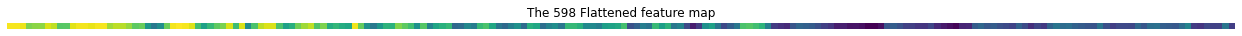

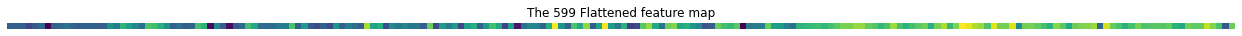

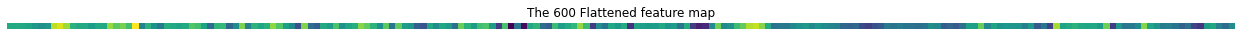

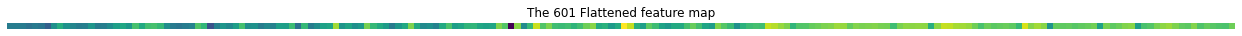

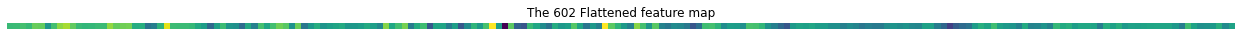

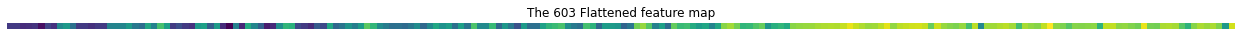

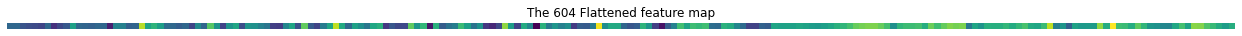

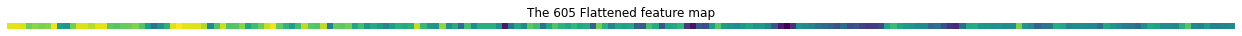

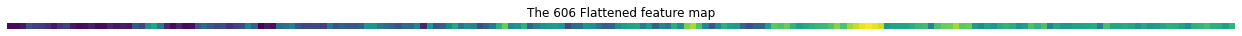

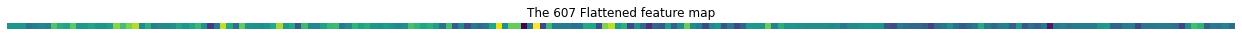

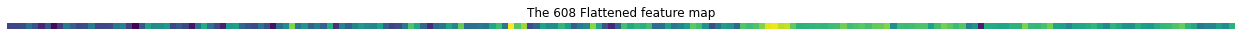

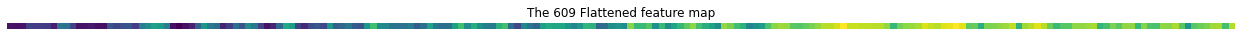

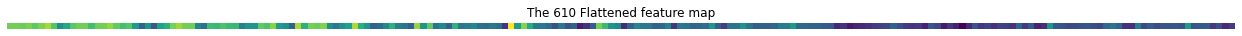

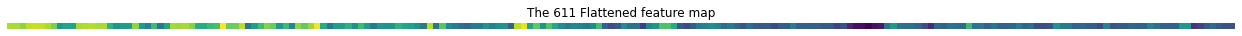

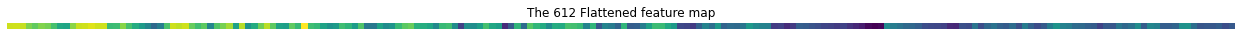

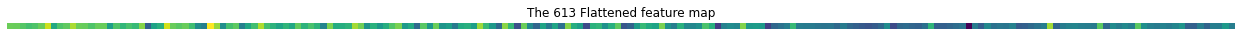

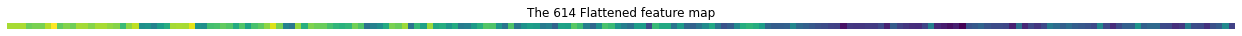

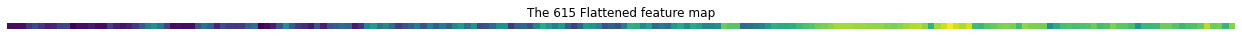

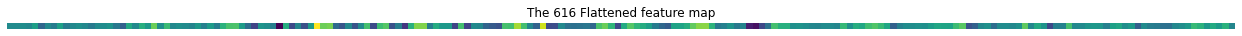

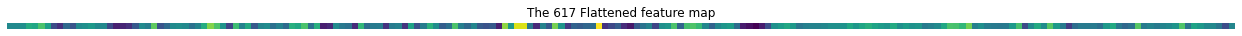

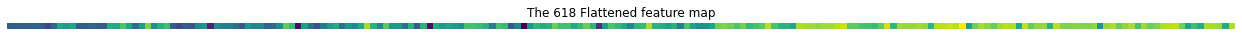

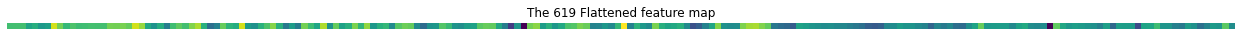

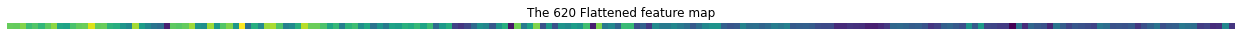

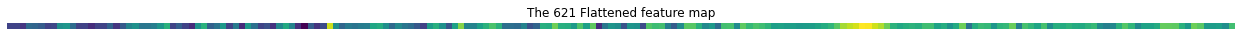

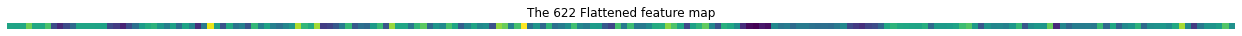

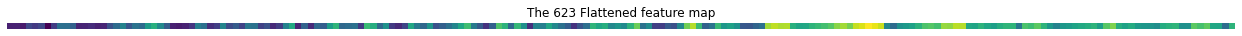

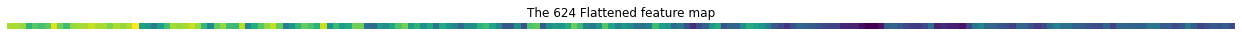

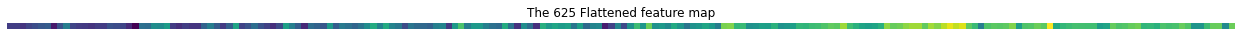

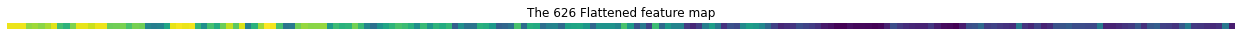

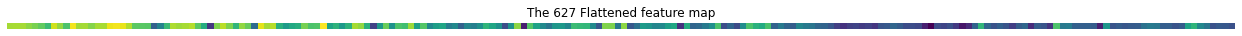

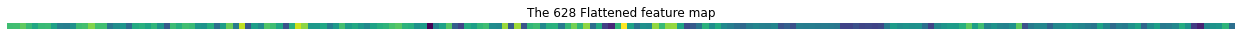

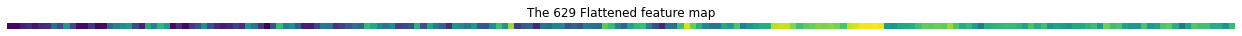

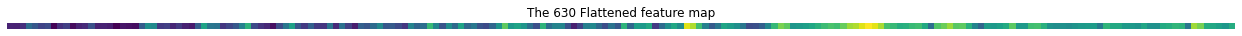

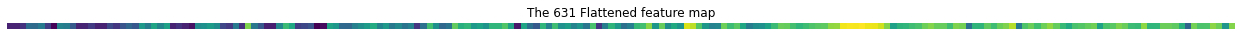

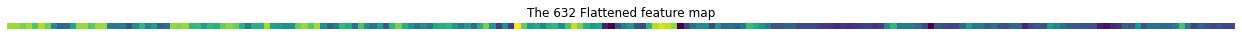

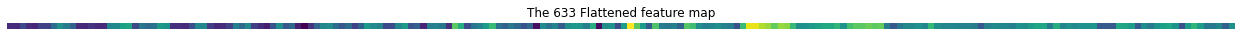

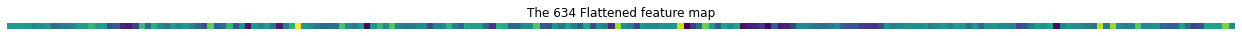

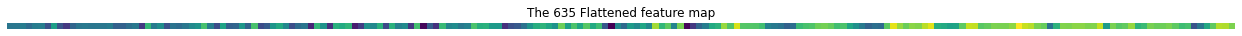

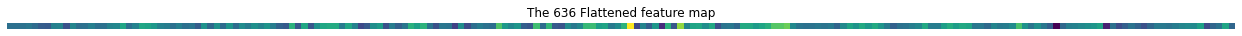

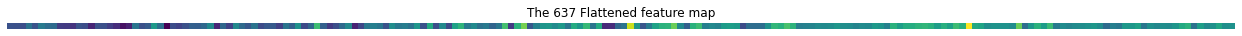

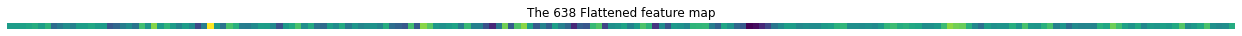

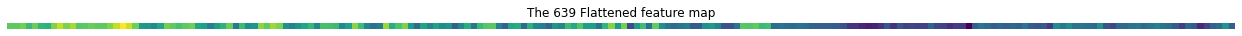

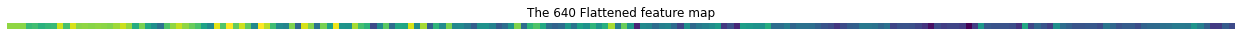

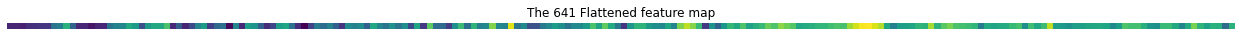

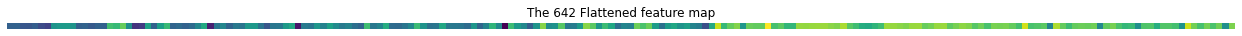

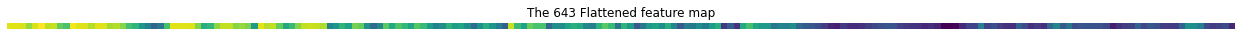

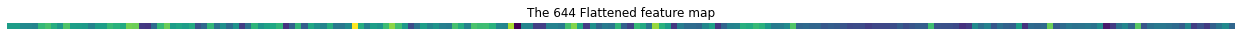

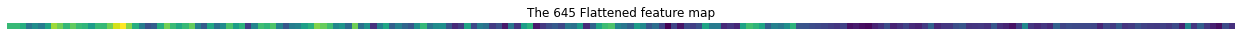

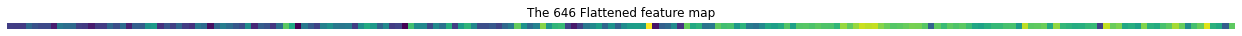

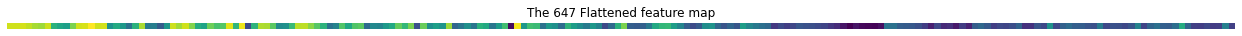

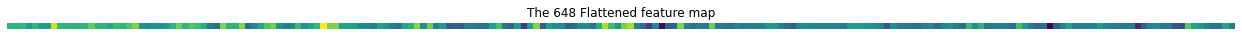

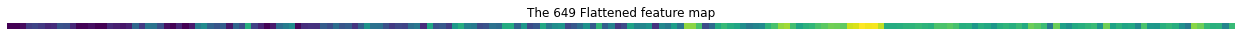

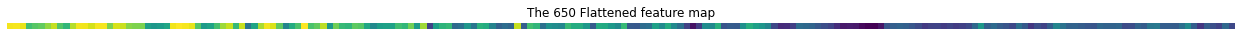

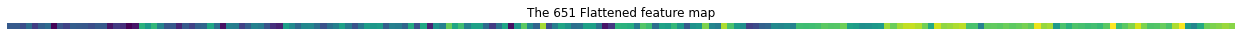

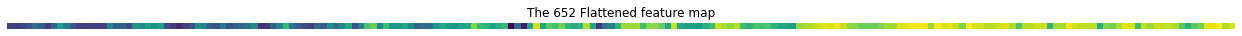

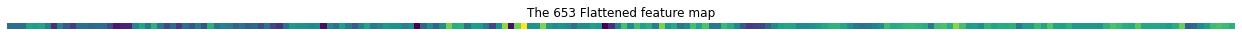

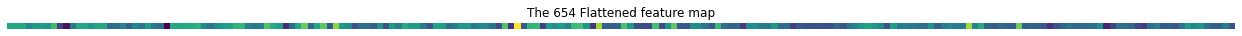

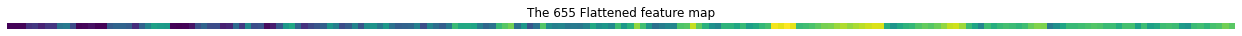

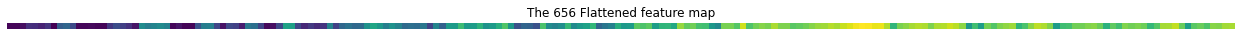

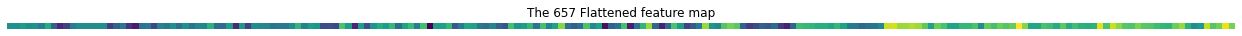

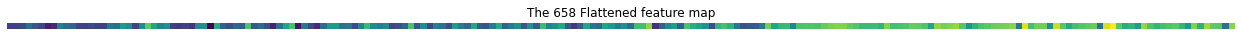

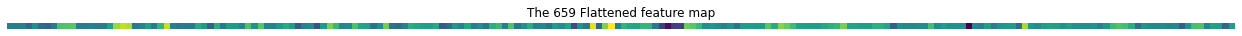

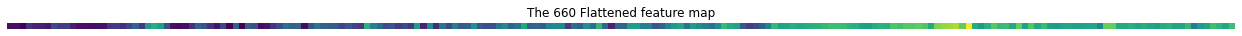

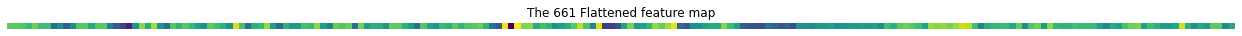

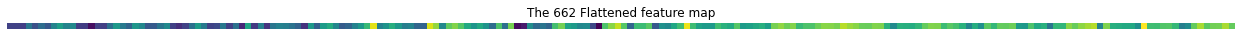

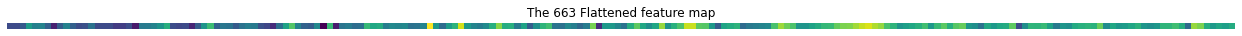

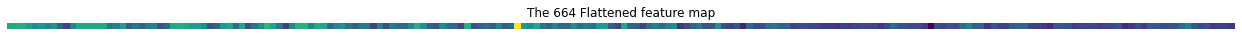

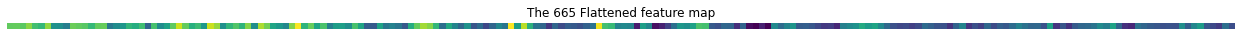

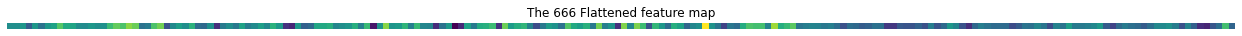

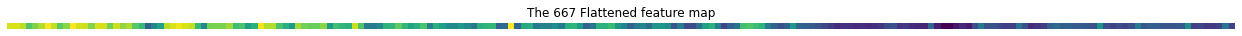

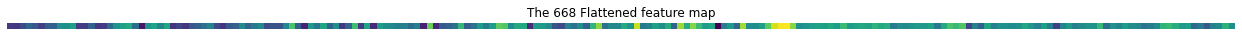

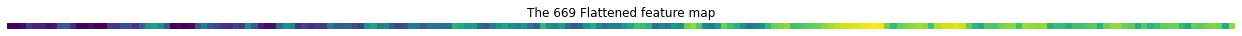

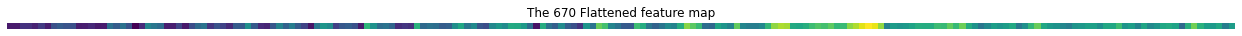

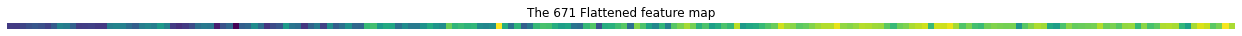

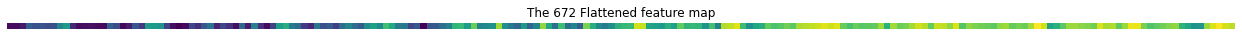

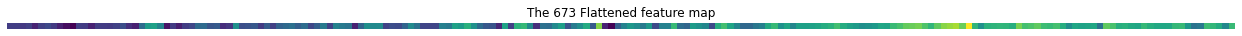

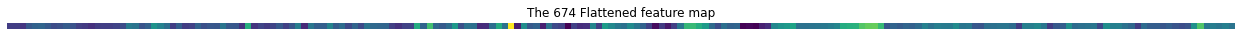

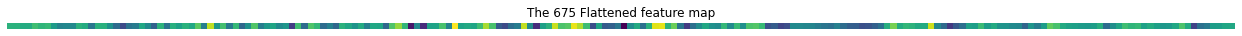

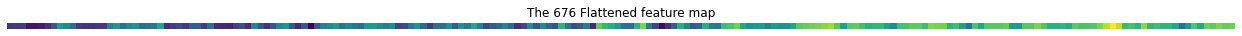

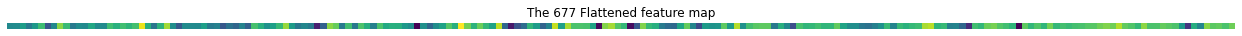

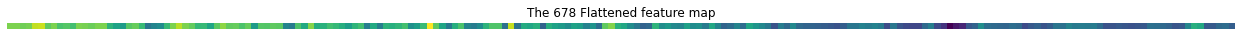

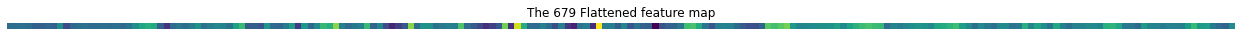

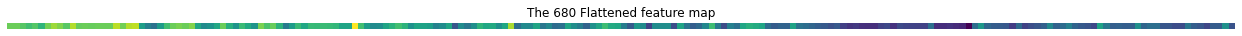

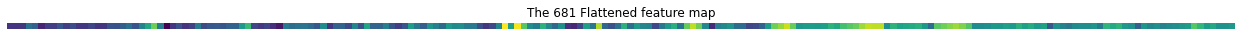

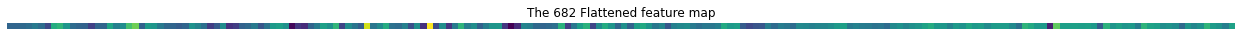

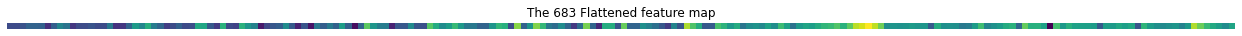

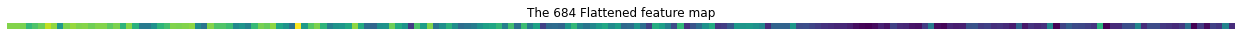

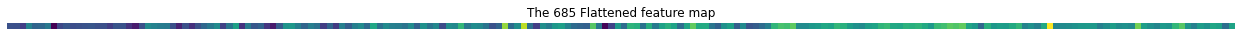

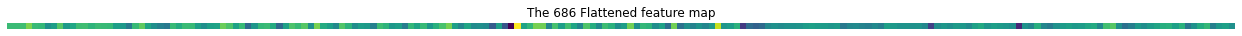

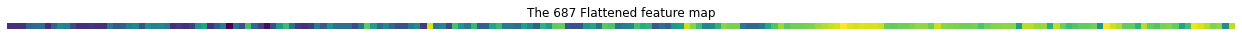

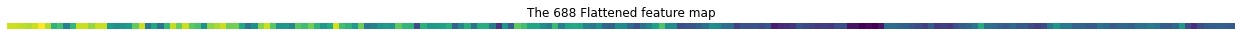

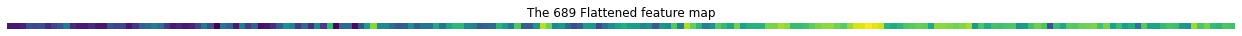

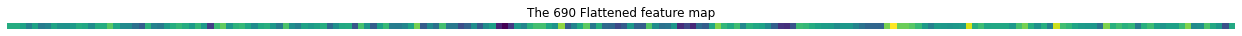

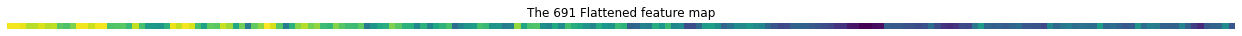

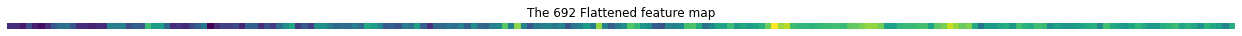

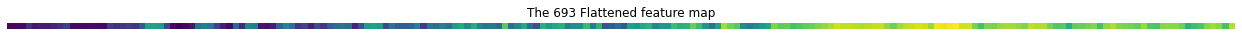

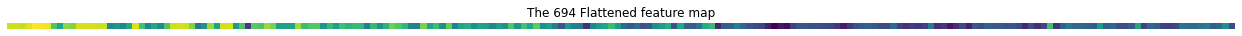

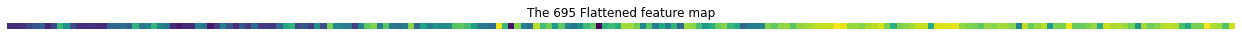

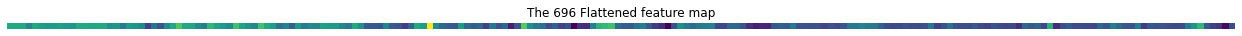

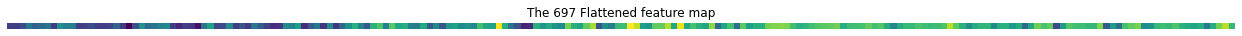

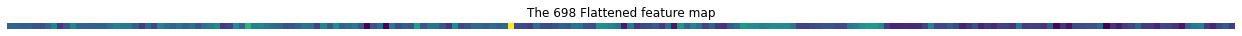

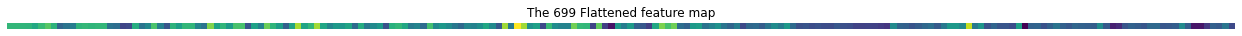

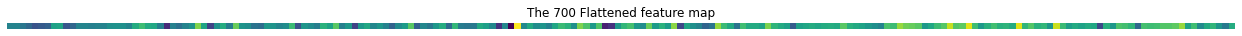

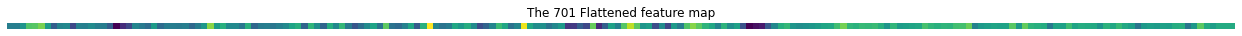

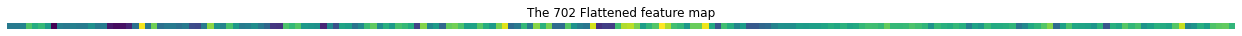

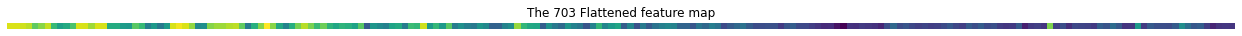

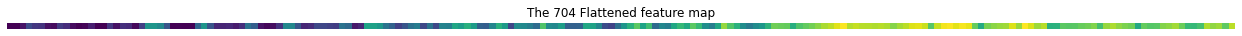

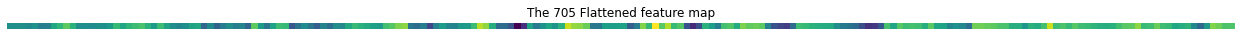

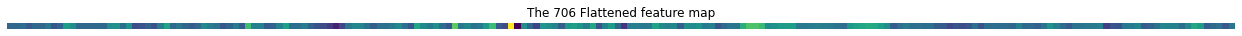

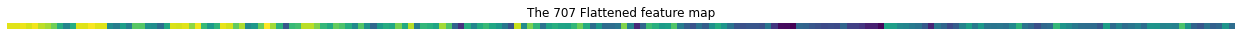

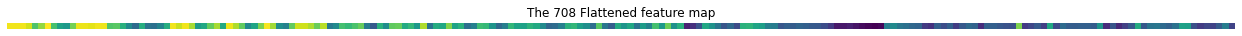

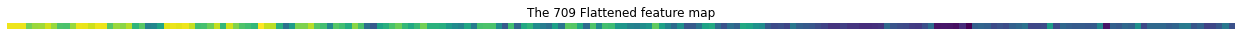

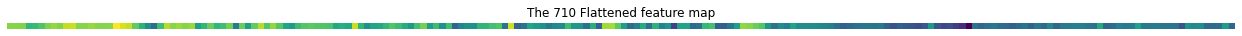

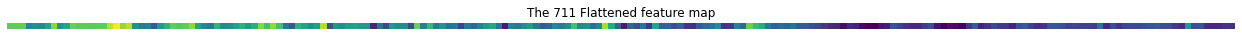

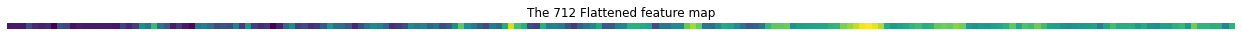

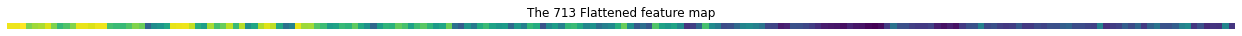

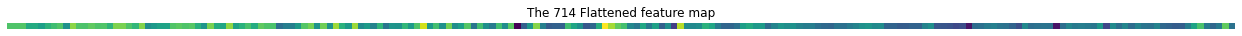

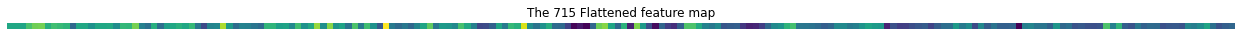

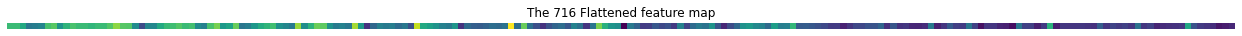

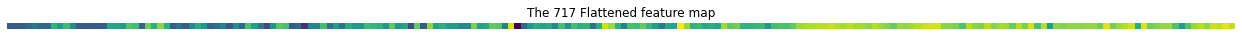

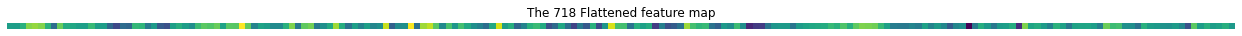

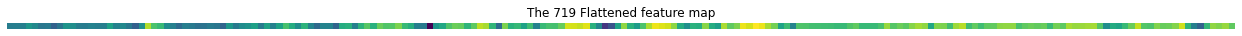

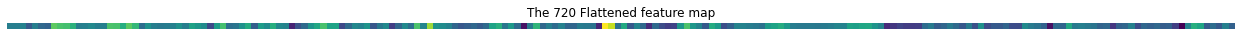

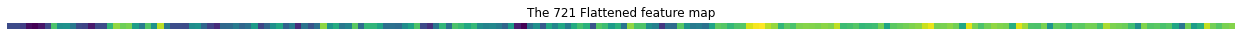

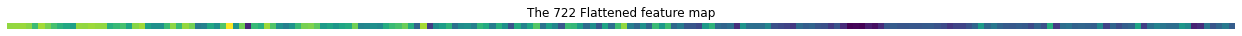

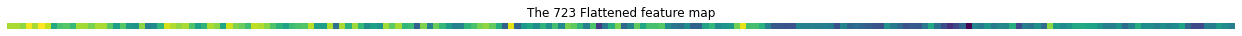

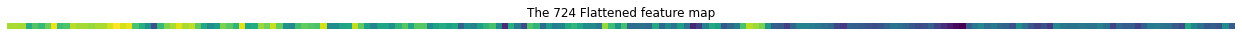

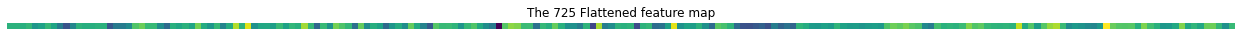

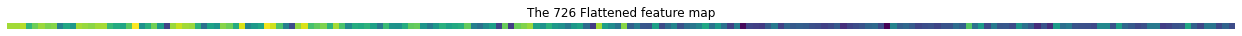

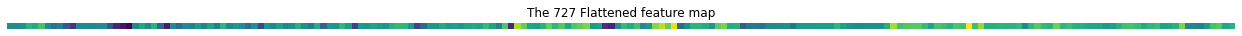

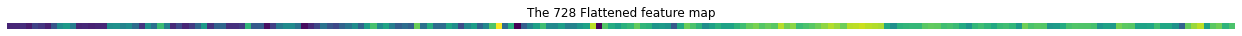

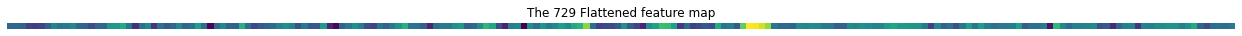

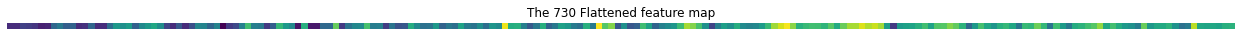

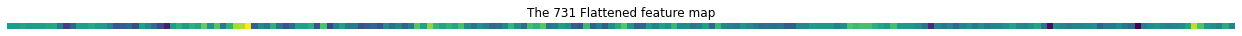

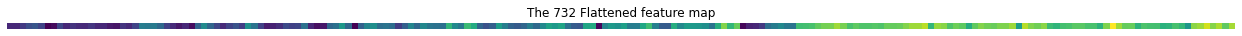

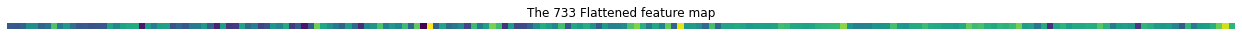

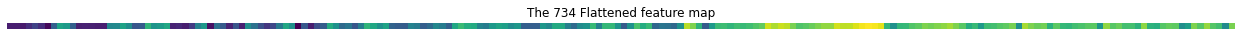

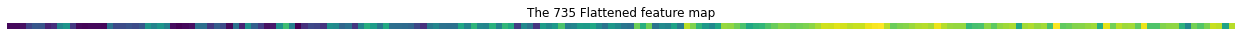

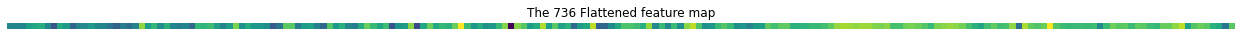

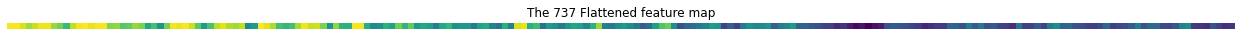

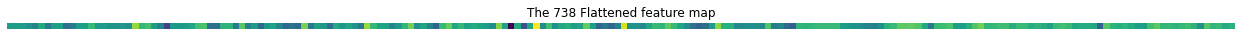

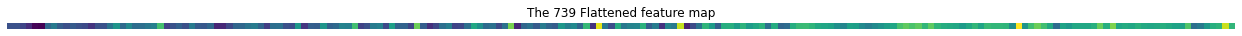

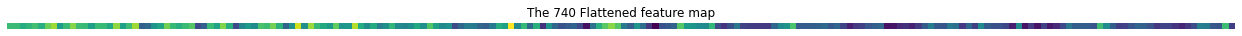

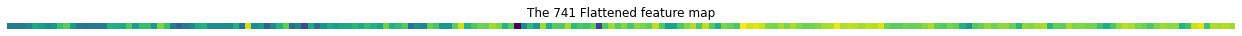

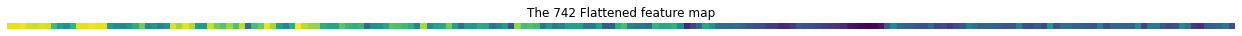

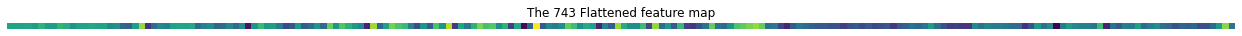

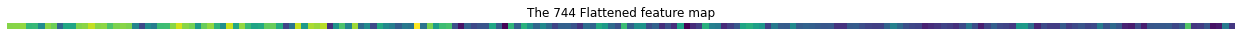

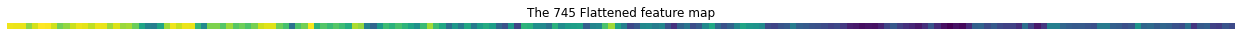

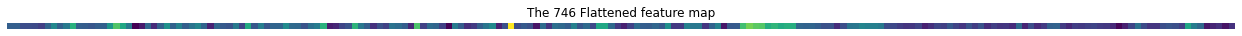

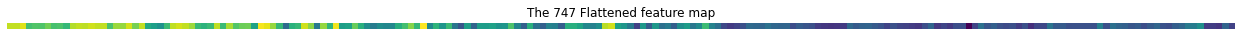

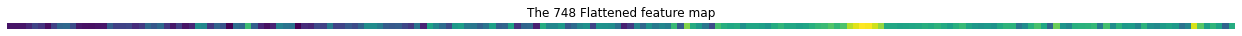

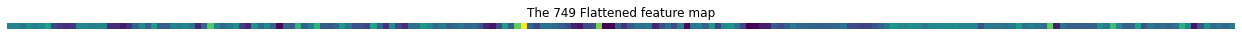

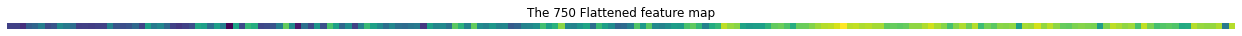

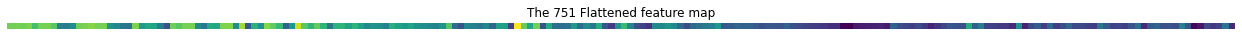

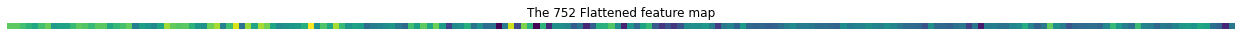

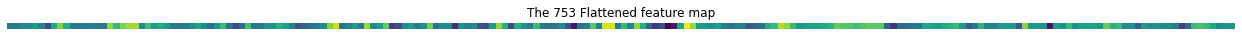

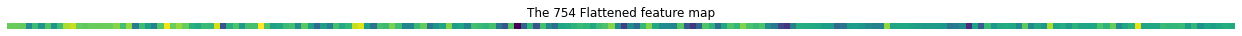

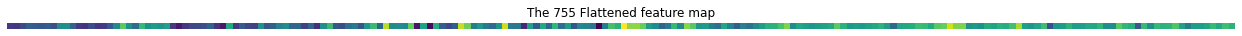

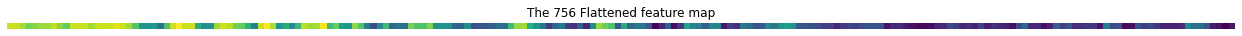

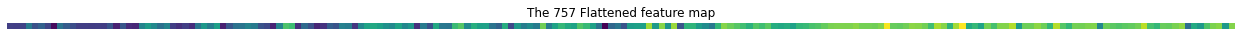

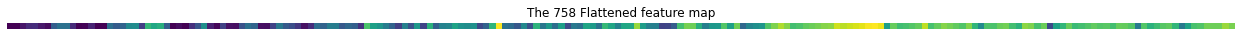

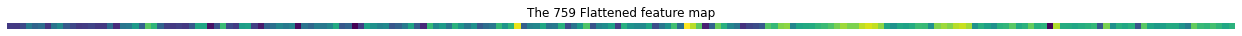

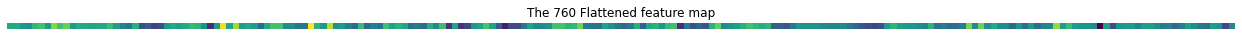

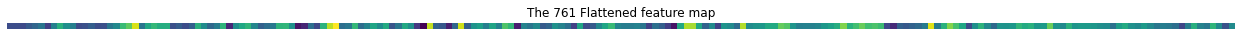

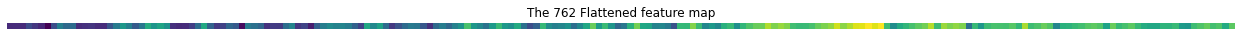

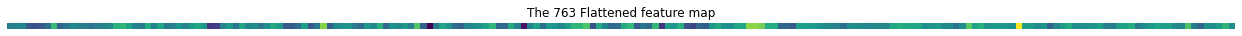

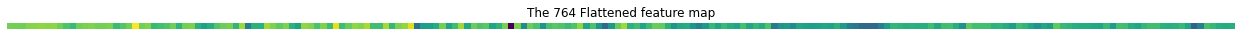

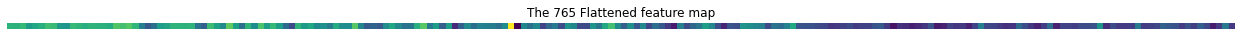

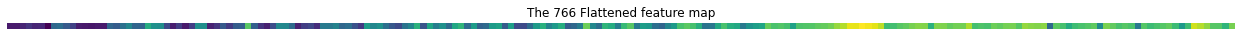

<Figure size 1584x1584 with 0 Axes>

In [35]:
for each in range(image_out_of_conv_flattened_reshaped.shape[2]):
    single_flattened = image_out_of_conv_flattened_reshaped[:, :, each]
    
    plt.figure(figsize=(22,22))
    plt.imshow(single_flattened.detach().numpy())
    plt.title(f"The {each} Flattened feature map")
    plt.axis(False);
    
plt.clf()

### 5. Turning the ViT patch embedding layer into a PyTorch module

In [36]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turning a 2D input image into a 1D sequence 
    learnable embedding vector.
    
    Args:
        in_channels(int): Num of color channels for the input imgs.
        Defaults to 3. 
        patch_size(int): Size of patches to convert input img into. 
        Defaults to 16.
        embedding_dim(int): Size of embedding to turn img inot. De
        faults to 768.
        
    """
    
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        
        
        # 3. Create a layer to turn an img into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # 4. Create a layer to flatten the patch feature maps into
        # a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
        # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are 
        # the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"img \
        size should be divisible by patch size, img shape -> \
        {image_resolution}, patch size -> {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)


        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)

In [37]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input img shape -> {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape -> {patch_embedded_image.shape}")

Input img shape -> torch.Size([1, 3, 224, 224])
Output patch embedding shape -> torch.Size([1, 196, 768])


In [38]:
# Create random input sizes
random_input_image = (1,3,224,224)
# random_input_image = (1,3,250,250)  # error-> incompatible with patchSize

# Get a summary of the input and outputs
summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", \
                   "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 6. Creating the class token embedding

In [39]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"patch shape -> {patch_embedded_image.shape}")

tensor([[[-0.0190, -0.0113, -0.0316,  ...,  0.0105, -0.0027,  0.0062],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0193, -0.0057, -0.0310,  ...,  0.0200,  0.0016,  0.0279],
         ...,
         [-0.7197,  0.0791, -0.1031,  ...,  0.4014, -0.3378,  0.2652],
         [-0.5890,  0.0334, -0.1584,  ...,  0.2433, -0.3407,  0.3799],
         [-0.7500,  0.1434, -0.1857,  ...,  0.4514, -0.3737,  0.3057]]],
       grad_fn=<PermuteBackward0>)
patch shape -> torch.Size([1, 196, 768])


> patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)

In [40]:
# Get the batch size and embedding dims
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1] 

# Create the class token embedding as a learnable parameter 
# that shares the same size as the embedding dim (D)

cls_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                         requires_grad=True)

# Show the first 10 examples of the class token
print(cls_token[:, :, :10])

# Print the class token shape
print(f"Class token shape -> {cls_token.shape} -> [batch, num_of_tokens, embeddings]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape -> torch.Size([1, 1, 768]) -> [batch, num_of_tokens, embeddings]


In [43]:
# Add the cls token embedding to the front of the patch embedding
patch_embedded_image_with_cls_embedding = torch.cat((cls_token, patch_embedded_image),
                                                    dim=1)

# Print the sequence of patch embeddings with the prepended cls token embedding
print(patch_embedded_image_with_cls_embedding)
print(f"Sequence of patch embeddings with cls token prepended shape -> {patch_embedded_image_with_cls_embedding.shape}\n -> [batch, num_of_patch, embedding_dim]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0190, -0.0113, -0.0316,  ...,  0.0105, -0.0027,  0.0062],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         ...,
         [-0.7197,  0.0791, -0.1031,  ...,  0.4014, -0.3378,  0.2652],
         [-0.5890,  0.0334, -0.1584,  ...,  0.2433, -0.3407,  0.3799],
         [-0.7500,  0.1434, -0.1857,  ...,  0.4514, -0.3737,  0.3057]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with cls token prepended shape -> torch.Size([1, 197, 768])
 -> [batch, num_of_patch, embedding_dim]


### 7. Creating the position embedding  
$$E_{pos} \in R ^{(N+1)\times D}$$  

* $N = HW/P^2 $  
* $D$ The size of the patch embeddings, in this calse 768

In [44]:
# View the sequence of patch embeddings with the prepended cls embedding
patch_embedded_image_with_cls_embedding, patch_embedded_image_with_cls_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0190, -0.0113, -0.0316,  ...,  0.0105, -0.0027,  0.0062],
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
          ...,
          [-0.7197,  0.0791, -0.1031,  ...,  0.4014, -0.3378,  0.2652],
          [-0.5890,  0.0334, -0.1584,  ...,  0.2433, -0.3407,  0.3799],
          [-0.7500,  0.1434, -0.1857,  ...,  0.4514, -0.3737,  0.3057]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [47]:
# Calculate N(num of patches)
num_of_patches = int((height * width) / patch_size**2)

# Get embedding dim
embedding_dim = patch_embedded_image_with_cls_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             num_of_patches+1,
                                             embedding_dim),
                                 requires_grad=True)

# Show the first 10 sequences and 10m position embedding values and check the shape 
# of position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape -> {position_embedding.shape} -> [batch, num_of_patches, embedding_dim]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape -> torch.Size([1, 197, 768]) -> [batch, num_of_patches, embedding_dim]


In [48]:
# Add the cls token and position embedding 
cls_and_position_embedding = patch_embedded_image_with_cls_embedding + position_embedding
print(cls_and_position_embedding)
print(f"Full embedding shape -> {cls_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9810, 0.9887, 0.9684,  ..., 1.0105, 0.9973, 1.0062],
         [0.9812, 0.9886, 0.9689,  ..., 1.0105, 0.9967, 1.0033],
         ...,
         [0.2803, 1.0791, 0.8969,  ..., 1.4014, 0.6622, 1.2652],
         [0.4110, 1.0334, 0.8416,  ..., 1.2433, 0.6593, 1.3799],
         [0.2500, 1.1434, 0.8143,  ..., 1.4514, 0.6263, 1.3057]]],
       grad_fn=<AddBackward0>)
Full embedding shape -> torch.Size([1, 197, 768])


### 8. Put all together

In [54]:
set_seeds()  # helper function

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the img dims
print(f"Original image shape -> {image.shape}")
height, width = image.shape[1], image.shape[2]

print(f"Original image height, and width -> {height, width}")

# 3. Get image tensor and add batch dim
x = image.unsqueeze(0)
print(f"image with batch dim -> {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape -> {patch_embedding.shape}")

# 6. Create cls token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
cls_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                         requires_grad=True)
print(f"Cls token embedding shape -> {cls_token.shape}")

# 7. Prepend cls token embedding to patch embedding
patch_embedding_cls_token = torch.cat((cls_token, patch_embedding), dim=1)
print(f"patch embedding with cls token -> {patch_embedding_cls_token.shape}")

# 8. Create position embedding
num_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, num_of_patches+1,  embedding_dim),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with cls token
patch_and_position_embedding = patch_embedding_cls_token + position_embedding
print(f"Full embedding shape -> {patch_and_position_embedding.shape}")

Original image shape -> torch.Size([3, 224, 224])
Original image height, and width -> (224, 224)
image with batch dim -> torch.Size([1, 3, 224, 224])
Patching embedding shape -> torch.Size([1, 196, 768])
Cls token embedding shape -> torch.Size([1, 1, 768])
patch embedding with cls token -> torch.Size([1, 197, 768])
Full embedding shape -> torch.Size([1, 197, 768])


![](08-vit-paper-architecture-animation-full-architecture.gif)

# Eq 2 -> Multi-Head Attenton
- torch.nn.MultiheadAttention()
    - `embed_dim`
    - `num_heads`
    - `dropout`
    - `batch_first`
- torch.n.LayerNorm()
- Residual connection

In [55]:
# 1. Creae a cls that inherits from nn.Module
class MultiheadSelfAttentionBlk(nn.Module):
    """
    Creates a multi-head self-attention block -> MSA
    """
    
    # 2. Initialzie the cls with hyperparameters
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads:     int=12,
                 attn_dropout:  float=0):
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [56]:
# Create an instance of MSABlk
multihead_self_attention_blk = MultiheadSelfAttentionBlk(embedding_dim=768,
                                                         num_heads=12)

# Pass patch and position img embedding through MSABlk
patched_img_through_msa_blk = multihead_self_attention_blk(patch_and_position_embedding)
print(f"Input -> {patch_and_position_embedding.shape}")
print(f"Output -> {patched_img_through_msa_blk.shape}")

Input -> torch.Size([1, 197, 768])
Output -> torch.Size([1, 197, 768])


# Eq3: Multilayer Perception
- `torch.nn.Linear()`
- `torch.nn.GELU()`
- `torch.nn.Dropout()`

In [63]:
# 1. Create a cls that inherits from nn.Module
class MLPBlk(nn.Module):
    """
    Creates a layer normalized multiplayer perceptron blk 
    """
    
    # 2. Initialize the cls with hyperparameters
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: float=.1):
        super().__init__()
        
        # 3. Create the norm layer
        # Notice the layer normalization tends to manipulate the data
        # along channel compares to batch normalization which it normalizes the data
        # along the batch of data with each individual channel data
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    # 5. Create a forward method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [64]:
# Instance of MLPBlk
mlp_blk = MLPBlk(embedding_dim=768,
                 mlp_size=3072,
                 dropout=.1)

# Pass output of MSABlk through MLPBlk
patched_img_through_mlp_blk = mlp_blk(patched_img_through_msa_blk)
print(f"Input shape -> {patched_img_through_msa_blk.shape}")
print(f"Output shape -> {patched_img_through_mlp_blk.shape}")

Input shape -> torch.Size([1, 197, 768])
Output shape -> torch.Size([1, 197, 768])


# Create the Transformer Encoder

In [ ]:
# 1. Create a cls taht inherits from nn.Modules
clas TransformerEncoderBlk(nn.Module):
    """
    Creates a Transformer Encoder blk
    """
    
    # 2. Initialize the cls with hyperparameters
    def __init__(self, 
                 embedding_dim:   int=768,
                 num_heads:       int=12,
                 mlp_size:        int=3072,
                 mlp_dropout:     float=.1,
                 attn_dropout:    float=0):
        super().__init()
        
        # 3. Create MSA blk 
        self.msa_blk = MultiheadSelfAttentionBlk(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
        
        # 4. Create MLP blk
        self.mlp_blk = MLPBlk(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
        
    # 5. forward method
    def forward(self, x):
        